# Figures and analysis to include in the Thesis

In [1]:
# imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import gzip
import anndata as ad
%matplotlib inline
# now, make regression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import sklearn.metrics
import sklearn as sk
import scanpy as sc
#import pyscenic.genesig #import GeneSignature
from pyscenic.aucell import create_rankings, enrichment, aucell, derive_auc_threshold, create_rankings
from ctxcore.genesig import GeneSignature
from pySCENIC_binarization import binarize
from pySCENIC_binarization import derive_threshold
import scanpy as sc
import pickle
import gzip
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
# functions
# Function to generate singature files (gmt)
def generateSignature(singnature_name, singature_genes, description='Description'):
    '''
    Generates one line of a signature file for gtm files
    Arguments:
        singnature_name      : type string
        singature_genes      : type list of strings
        description          : (Optional) singature description if available
    '''
    return singnature_name + '\t' + description + '\t'+ '\t'.join(singature_genes)

def loadSCENICResult(path, genes=None, min_regulon_size= 1, weights=None):
    """
    Helper function to load the scenig result (zero-one file for all TF-targets per regulon)
    Carefull: colnames can be duplicate gene names, depending on which motifs were found 
    """
    weight_dic = {}
    # load and process weights
    #print("WHy does it not print???")
    if weights != None:
        df_w = pd.read_csv(weights,sep='\t')
        for TF, TG, W in zip(df_w['TF'], df_w['target'],df_w['importance']):
            weight_dic[TF+'~'+TG] = W
           # print(TF+'~'+TG,  W)

    # Load GRN
    GRN_full_df =  pd.read_csv(path, sep=',', index_col = 0)

    # get all Regulon names
    TF_names = {}
    for i in list(GRN_full_df.columns):
        if i != 'regulonMatrix.gene' and i != 'genes':
            TF_names[i] = i.replace('regulonMatrix.', '').split('_')[0]
    
    # clean up wrong column names:
    if 'gene' in TF_names:
        del TF_names['gene']
    
    #print(TF_names)
    TF_TG_interactions          = {}
    TF_TG_interactions_weighted = {}
    
    if genes != None:
        for i in TF_names:
            interactions  = []
            status        = []
            weight_list   = []
            for index, row in GRN_full_df[i].items():
#                return
#                # make a filter step to check whether gene name is present in dataframe
                if index in genes:
                    interactions.append(TF_names[i]+'~'+index)
                    status.append(abs(int(row)))
                    if weights!= None:
                        if TF_names[i]+'~'+index in weight_dic:
                            weight_list.append(weight_dic[TF_names[i]+'~'+index])
                        else:
                             weight_list.append(0)
                
            # add a regulon size filter at this position, setting a minimum amount of edges per regulon
            df = pd.DataFrame(list(zip(interactions, status)), columns =['Interaction', 'Status'])
            df_2 = pd.DataFrame(list(zip(interactions, weight_list)), columns =['Interaction', 'weight_list'])
            if len(df[df['Status'] > 0]) >= min_regulon_size:
                TF_TG_interactions[TF_names[i]] = pd.DataFrame(list(zip(interactions, status)), columns =['Interaction', 'Status'])
                if weights!= None:
                    TF_TG_interactions_weighted[TF_names[i]] = pd.DataFrame(list(zip(interactions, weight_list)), columns =['Interaction', 'Status'])
    else:
        for i in TF_names:
            #print(i)
            interactions  = []
            status        = []
            weight_list   = []
            for index, row in GRN_full_df[i].items():
                interactions.append(TF_names[i]+'~'+index)
                status.append(abs(int(row)))
                if weights!= None:
                    if TF_names[i]+'~'+index in weight_dic:
                        weight_list.append(weight_dic[TF_names[i]+'~'+index])
                    else:
                        weight_list.append(0)
            #print(len(interactions), len(status), len(weight_list))  
            # add a regulon size filter at this position, setting a minimum amount of edges per regulon
            df = pd.DataFrame(list(zip(interactions, status)), columns =['Interaction', 'Status'])
            df_2 = pd.DataFrame(list(zip(interactions, status)), columns =['Interaction', 'weight_list'])
            if len(df[df['Status'] > 0]) >= min_regulon_size:
                TF_TG_interactions[TF_names[i]] = pd.DataFrame(list(zip(interactions, status)), columns =['Interaction', 'Status'])
                if weights!= None:
                    TF_TG_interactions_weighted[TF_names[i]] = pd.DataFrame(list(zip(interactions, weight_list)), columns =['Interaction', 'Status'])
    #print(TF_TG_interactions_weighted)

    return TF_TG_interactions, TF_TG_interactions_weighted

def intersection(lst1, lst2):
    lst2 = dict.fromkeys(lst2, [])
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def intersect_pf(Regulon_to_compare, ChIP_gold_df):
    """
    The goal of this function is to intersect entries that were consideret inthe inferred networks with interations present in the gold standard
    Also remove duplicates, in case they could appear for some reason in the Gold Standard.
    The function works because both dataframes have ALL possible interactions realised, meaning each TG-TF pair that was measured
    or was in the gold standard has an id (and can be 0 or 1, whether it exists or not).
    Each regulon TF in a sample is therefore compared to the gold standard for ALL possible gene interactions. 
    The filtered out interactions with genes that were not measured in the gold standard, or were not measured in the dataset 
    """
    # Drop dupliate interactions (normally they do not exist)
    Regulon_to_compare.drop_duplicates(subset=['Interaction'], inplace = True)
    ChIP_gold_df.drop_duplicates(subset=['Interaction'], inplace = True)
    # Get interactions of the same id's
    same_ids = intersection(list(Regulon_to_compare['Interaction']),list(ChIP_gold_df['Interaction']))
    #print("check stats:", len(same_ids))
    #print(list(Regulon_to_compare['Interaction']))
    #print(ChIP_gold_df['Interaction'])
    I_TG =  Regulon_to_compare[Regulon_to_compare['Interaction'].isin(same_ids)] 
    I_Gold =  ChIP_gold_df[ChIP_gold_df['Interaction'].isin(same_ids)] 
    
    # sort both datasets, so that the index of an interaction is the same between both
    I_TG   = I_TG.sort_values(by=['Interaction'], ignore_index=True, inplace=False)
    I_Gold = I_Gold.sort_values(by=['Interaction'],  ignore_index=True, inplace=False)
    
    return I_TG,I_Gold


def prepareCollecTRIGoldStandard(path, evidence_score=1, complex_filter = 'complex_removed'):
    """
    Function to load CollecTRI, filter it based on evidence, and return two gold standards: Full and filtered.
    For complex_filter, one can set all (no filtering), complex_only (only complexes), complex_removed (only non 
    complex interactions)
    """
    # load CollecTRI into pandas dataframe
    CTRI              = pd.read_csv(path,sep='\t')
    # annotate whether an interaction is a complex (allows to remove them later)
    complex_indicator = [True if 'COMPLEX' in i else False for i in list(CTRI['source'])]
    CTRI['is_complex'] = complex_indicator

    # Test filter
    if complex_filter == 'complex_only':
        CTRI = CTRI[ CTRI['is_complex'] == True]
    elif complex_filter == 'complex_removed':
        CTRI = CTRI[ CTRI['is_complex'] == False]
    else:
        CTRI = CTRI
    
    # Make gold standard for unfiltered case:
    # Get TG and TF names
    TFs = {}
    TGs = {}
    for i in CTRI['source']:
        TFs[i] = []
    for i in CTRI['target']:
        TGs[i] = []    

    for i in list(zip(CTRI['source'], CTRI['target'])):
        TFs[i[0]].append(i[1])
        
    #print(TFs)
    
    # Ceate TF-TG interaction dataframes for all
    TF_TG_interactions_full = {}
    for TF in TFs:
        interaction_list = []
        status_list      = []
       # print(TF)
        
        for TG in TGs:         
            if TG in TFs[TF]:
                interaction_list.append(TF+'~'+TG)
                status_list.append(1)
            else:
                interaction_list.append(TF+'~'+TG)
                status_list.append(0)
        TF_TG_interactions_full[TF] = pd.DataFrame(list(zip(interaction_list, status_list)), columns =['Interaction', 'Status'])
    #print(TF_TG_interactions_full)

    # Make gold standard for filtered case:
    CTRI = CTRI[CTRI['curation_effort'] >= evidence_score]
    
    # Get TG and TF names
    TFs = {}
    TGs = {}
    for i in CTRI['source']:
        TFs[i] = []
    for i in CTRI['target']:
        TGs[i] = []    

    for i in list(zip(CTRI['source'], CTRI['target'])):
        TFs[i[0]].append(i[1])
    
    # Ceate TF-TG interaction dataframes for all
    TF_TG_interactions_filtered = {}
    for TF in TFs:
        interaction_list = []
        status_list      = []

        for TG in TGs:
            if TG in TFs[TF]:
                interaction_list.append(TF+'~'+TG)
                status_list.append(1)
            else:
                interaction_list.append(TF+'~'+TG)
                status_list.append(0)
        TF_TG_interactions_filtered[TF] = pd.DataFrame(list(zip(interaction_list, status_list)), columns =['Interaction', 'Status'])

    
        
    return(TF_TG_interactions_full, TF_TG_interactions_filtered)


def normalizeImportanceScores(scores, top_k_threshold=None, scaling_factor=100):
    """
    Take all importance scores, and rank them by their relative contribution with regard to 
    the total sum of importance scores.
    """
    new_scores = scores.copy()
    for TG in scores:
        if top_k_threshold == None:
            sum_over_scores = np.sum(list(scores[TG].values()))
        else:
            sum_over_scores = np.sum(sorted(list(scores[TG].values()), reverse=True)[:top_k_threshold]) 
        for TF in scores[TG]:
            new_scores[TG][TF] = (scores[TG][TF]/sum_over_scores)*scaling_factor
    return new_scores

def normalizeForModelPerformance(scores, performance, scaling_factor=1, score_type=1):
    """
    Take all importance scores, and multiply them by a factor that represents
    the [0-1] scaled model performance. Model performance is calcuated relatively to offset the different
    expression ranges by validating it against a mean baseline (mae_prediction/mean_TG)
    The performance dictionary contains tuples of (mean, train_error, test_error)
    """
    new_scores = scores.copy()

    # prepare model scaling factor
    error             = []
    mean              = []
    error_mean_ratio  = {}
    for i in performance:
        #if performance[i][0]:
        mean.append(performance[i][0])
        error.append(performance[i][1])
        if mean[-1] > 0:
            error_mean_ratio[i] = error[-1]/mean[-1]   # if error < mean, the coefficient is < 1
        else:
            error_mean_ratio[i] = 5

    # Divide each error_mean_ratio by the maxium mean_error ration.
    # Then build the inverse, as the lower values indicate better performance
    max_error_mean_ratio = max(error_mean_ratio.values())
    
    for TG in error_mean_ratio:
        error_mean_ratio[TG] =  1-(error_mean_ratio[TG]/max_error_mean_ratio)    
    
    for TG in scores:
        for TF in scores[TG]:
            new_scores[TG][TF] = scores[TG][TF] * error_mean_ratio[TG]
    return new_scores




def makePandasNetwork(regulons, interactions):
    """
    Use on regulons and interactions to create a data structure: 
    Dictionary with TFs as keys and pandas DataFrame of all TGs
    Two columns: Interactions [TF~TG] and Status. Status takes 0 or 1 for binary indication of an edge, or the weight of the edge.
    """
    # Create TF_TG_interactions_binary and TF_TG_interactions_weighted
    #all_target_genes = set(TG for _, TG, _ in selected_interactions)
    all_target_genes = set([x.split('~')[1] for x in  list(interactions.keys())])
    
    TF_TG_interactions_binary = {}
    TF_TG_interactions_weighted = {}

    for TF, tg_dict in regulons.items():
        # Prepare the interaction and status lists
        interaction_list = []
        status_binary_list = []
        status_weighted_list = []

        # Iterate over all target genes to build interaction keys and status
        for target_gene in all_target_genes:
            interaction_key = f"{TF}~{target_gene}"
            interaction_list.append(interaction_key)

            # For binary interaction (1 if interaction exists, 0 if not)
            status_binary = 1 if interaction_key in interactions else 0
            status_binary_list.append(status_binary)

            # For weighted interaction (importance score)
            status_weighted = tg_dict.get(target_gene, 0)
            status_weighted_list.append(status_weighted)

        # Create DataFrames
        TF_TG_interactions_binary[TF] = pd.DataFrame({
            'Interaction': interaction_list,
            'Status': status_binary_list
        })

        TF_TG_interactions_weighted[TF] = pd.DataFrame({
            'Interaction': interaction_list,
            'Status': status_weighted_list
        })    

    return TF_TG_interactions_binary, TF_TG_interactions_weighted


def makeCustomNetwork(scores, minimum_regulon_size=10, number_edges=100000, filter_TGs=None, verbose=True):
    """
    Make a custom network based on the XGBoost scores.
        scores:                scored TF interactions per model
        minimum_regulon_size:  limit size of regulons
        number_edges:          target goal of number of egdes to include
        filter_TFs:            set of TGs to keep. Useful to either include or exclude models based on their quality
    """
    # Reverse dictionary structure: TG -> {TF: score} -> TF -> {TG: score}
    inital_interactions = []
    TF_list             = []
    TG_list             = []
    score_list          = []

    for TG, tf_dict in scores.items():
        # filter out TGs that are not in set if filter_TGs == True
        if filter_TGs !=  None and TG not in filter_TGs:
            continue
        for TF, score in tf_dict.items():
            inital_interactions.append((TF, TG, score))
            TF_list.append(TF)
            TG_list.append(TG)
            score_list.append(score)
    
    df = pd.DataFrame({'TF':TF_list, 'TG':TG_list, 'score':score_list})
    df.sort_values(by='score', inplace=True, ascending=False)
    
    inital_interactions = [tuple(row) for row in df.itertuples(index=False, name=None)]


    if verbose:
        print(f"Total initial interactions: {len(inital_interactions)}")

    # Ensure we do not exceed available edges
    number_edges = min(number_edges, len(inital_interactions))

    # Find the threshold score at position `number_edges`
    thres = inital_interactions[number_edges - 1][2]  # (TF, TG, score) → score
    #print(len(inital_interactions), number_edges, thres, inital_interactions[number_edges - 1][2], inital_interactions[number_edges - 1])
    if np.isnan(thres):
        thres = 0
    #print(thres)
    if verbose:
        print(f"Threshold: {thres}")

    # Collect exactly `number_edges` edges, handling ties deterministically
    selected_interactions = []

    for TF, TG, score in inital_interactions:
        #print(TF, TG, score)

        if len(selected_interactions) >= number_edges:
            break
        if score > thres or (score == thres and len(selected_interactions) < number_edges):
            selected_interactions.append((TF, TG, score))
            
    if verbose:
        print(f"Final edge count: {len(selected_interactions)}")

    # Convert back to TF -> {TG: score} structure
    regulons = {}
    interactions = {}
    
    for TF, TG, score in selected_interactions:
        regulons.setdefault(TF, {})[TG] = score
        interactions[f"{TF}~{TG}"] = score

    # Remove small regulons
    regulons = {TF: tg_dict for TF, tg_dict in regulons.items() if len(tg_dict) >= minimum_regulon_size}
    interactions = {f"{TF}~{TG}": score for TF, tg_dict in regulons.items() for TG, score in tg_dict.items()}
    
    # create weighted and binary pandas dataframes
    TF_TG_interactions_binary, TF_TG_interactions_weighted = makePandasNetwork(regulons, interactions)
        
    return regulons, interactions, TF_TG_interactions_binary, TF_TG_interactions_weighted

def rank_dict_values(interactions):
    """
    Replace values in a dictionary with their rank.
    The highest value gets the highest numerical rank.
    """
    sorted_items = sorted(interactions.items(), key=lambda x: x[1], reverse=False)
    #print(sorted_items[:1000])
    ranks = {key: rank+1 for rank, (key, _) in enumerate(sorted_items)}
    #print(sorted_items[0], sorted_items[100], sorted_items[1000], sorted_items[-1])
    #print(ranks[0], ranks[100], ranks[1000], ranks[-1])
    #print(ranks)
    #break
    return ranks


def rankIntegration(list_interactions, mode='maxrank', interactions = 30000, minimum_regulon_size = 10, verbose=False):
    """
    Function to integrate two or more networks based on the rank of interactions. Differernt integration modes are:
    maxrank:    Per interaction, take the maximum rank across all networks => This mode preserves best individual high ranks between networks
    meanrank:   This gives an option to downrank/uprank a gene based on consensus mean
    medianrank: This gives an option to downrank/uprank a gene based on consensus median
    minrank:    A meme implementation for test reasons. Expected to give you the worst network in comparison
    boostrank:  Tries to given an advantage ot edges that were found in multiple models. Same as meanrank, but considers the worsed rank for
                edges that do not exist in one model

    Input:  list_interactions
    Output: regulons_integrated, interactions_integrated, TF_TG_interactions_binary, TF_TG_interactions_weighted
    """

    # get all possible interactions 
    all_possible_interactions = set()
    for network in list_interactions:
        all_possible_interactions.update(set(list(network.keys())))

    print(len(all_possible_interactions))
        
    ranked_networks = []
    # calculate ranks (lowest rank = highest value)
    for network in list_interactions:
        ranked_networks.append( rank_dict_values(network) )
    #print(ranked_networks[1])
    integrated_interactions = {}
    # start the integration
    #print(all_possible_interactions)
    for interaction in all_possible_interactions:
        if mode == 'maxrank':
            ranks = []
            for network in ranked_networks:
                if interaction in network:
                    ranks.append(network[interaction])
            integrated_interactions[interaction] = max(ranks)
        if mode == 'minrank':
            ranks = []
            for network in ranked_networks:
                if interaction in network:
                    ranks.append(network[interaction])
            integrated_interactions[interaction] = min(ranks)
        if mode == 'meanrank':
            ranks = []
            for network in ranked_networks:
                if interaction in network:
                    ranks.append(network[interaction])
            integrated_interactions[interaction] = np.mean(ranks)
        if mode == 'medianrank':
            ranks = []
            for network in ranked_networks:
                if interaction in network:
                    ranks.append(network[interaction])
            integrated_interactions[interaction] = np.median(ranks)
        if mode == 'boostrank':
            ranks = []
            for network in ranked_networks:
                if interaction in network:
                    ranks.append(network[interaction])
                else:
                    ranks.append(1)
            integrated_interactions[interaction] = np.mean(ranks)
        if mode == 'sumrank':
            ranks = []
            for network in ranked_networks:
                if interaction in network:
                    ranks.append(network[interaction])
            integrated_interactions[interaction] = np.sum(ranks)
        if mode == 'supportrank':
            support = 2
            ranks = []
            for network in ranked_networks:
                if interaction in network:
                    ranks.append(network[interaction])
            if len(ranks) >= support:
                integrated_interactions[interaction] = max(ranks)

    #print(integrated_interactions)
    # prune edges to desired number if necessary
    if interactions == 'all':
        interactions = len(integrated_interactions)

    # Collect exactly `number_edges` edges, handling ties deterministically
    print(len(integrated_interactions))

    if verbose:
        print(f"Total initial interactions: {len(inital_interactions)}")

    # Ensure we do not exceed available edges
    number_edges = min(interactions, len(integrated_interactions))

    # Find the threshold score at position `number_edges`
    thres = sorted(list(integrated_interactions.values()), reverse=True)[number_edges - 1]  # (TF, TG, score) → score
    #print(sorted(list(integrated_interactions.values()), reverse=True))
    #print(sorted(list(integrated_interactions.values()), reverse=True))
    #print(thres, number_edges)
    #print(number_edges)
    selected_interactions = []
    for edge in integrated_interactions:
        TF = edge.split('~')[0]
        TG = edge.split('~')[1]
        score = integrated_interactions[edge]
        #print(TF, TG, score)
        if len(selected_interactions) >= number_edges:
            break
        if score > thres:# or (score == thres and len(integrated_interactions) < number_edges):
            selected_interactions.append((TF, TG, score))
        
    #print(selected_interactions)
    if verbose:
        print(f"Final edge count: {len(selected_interactions)}")

    # Convert back to TF -> {TG: score} structure
    regulons = {}
    interactions = {}
    print(len(selected_interactions))
    for TF, TG, score in selected_interactions:
        regulons.setdefault(TF, {})[TG] = score
        interactions[f"{TF}~{TG}"] = score
    print(len(interactions))
    # Remove small regulons
    regulons = {TF: tg_dict for TF, tg_dict in regulons.items() if len(tg_dict) >= minimum_regulon_size}
    interactions = {f"{TF}~{TG}": score for TF, tg_dict in regulons.items() for TG, score in tg_dict.items()}
    
    # create weighted and binary pandas dataframes
    TF_TG_interactions_binary, TF_TG_interactions_weighted = makePandasNetwork(regulons, interactions)
    # get regulons from integrated_interactions:
    return regulons, interactions, TF_TG_interactions_binary , TF_TG_interactions_weighted       
    
    
#regulons_int, interactions_int, TF_TG_interactions_binary_int, TF_TG_interactions_weighted_int  =rankIntegration([interactions_exp_exp, interactions_act_act], interactions=30000, mode='maxrank')
                
# regulons_exp_exp_bad, interactions_exp_exp_bad, TF_TG_interactions_binary_exp_exp_bad, TF_TG_interactions_weighted_exp_exp_bad = makeCustomNetwork(new_scores_all, minimum_regulon_size=10, number_edges=30000, filter_TGs=all_models_bad_TGs['exp_exp'] ,  verbose=False)
# regulons_exp_exp_bad
def delineateComplexScores(scores, mode='max'):
    """
    This function asigns individual scores to each TF that is involved in a complex.
    Right now, every TF is assigned it's highest score that it archived across all complexes
    """
    new_scores =  {}
    for TG in scores:
        new_scores[TG] = {}
        for TF in scores[TG]:
            #print(TF, scores[TG][TF])
            if '~' in TF:
                TFs = TF.split('~')
                #print(TFs)
                for i in TFs:
                    if i not in new_scores[TG]:
                        new_scores[TG][i] = scores[TG][TF]
                    else:
                        if new_scores[TG][i] < scores[TG][TF]:
                             new_scores[TG][i] =  scores[TG][TF]
            else:
                if TF not in new_scores[TG]:
                    new_scores[TG][TF] = scores[TG][TF]
                else:
                    if new_scores[TG][TF] < scores[TG][TF]:
                        new_scores[TG][i] =  scores[TG][TF]    
    return new_scores

# def makeTFBSenrichedNetwork(df, minimum_regulon_size=10, number_edges=100000, filter_TGs=None, verbose=True):
#     """
#     Take a pandas data frame with information about motif enrichment per TF and make a network out of it.
#     """
#     df_sorted = df.sort_values(by='log2_odds_ratio', ascending=False)
    
#     print('Jens')
#     for row in df_sorted.itertuples(index=True, name='Row'):
#         print(row.TF, row.TG, row.log2_odds_ratio)

def makeTFBSenrichedNetwork(df, minimum_regulon_size=10, number_edges=100000, filter_TGs=None, verbose=True):
    """
    Take a pandas DataFrame with information about motif enrichment per TF and make a network out of it.
        df:                  DataFrame with columns ['TF', 'TG', 'log2_odds_ratio']
        minimum_regulon_size: Minimum size of a regulon to keep
        number_edges:         Maximum number of edges to include
        filter_TGs:           Set of TGs to keep. Useful to include/exclude specific TGs
    """
    # Sort by log2 odds ratio (descending)
    df_sorted = df.sort_values(by='log2_odds_ratio', ascending=False)

    # Filter out rows with infinite scores
    df_sorted = df_sorted[np.isfinite(df_sorted['log2_odds_ratio'])]
    
    # Apply target gene filtering if provided
    if filter_TGs is not None:
        df_sorted = df_sorted[df_sorted['TG'].isin(filter_TGs)]
    
    # Limit to the top N edges
    df_sorted = df_sorted.head(number_edges)
    
    if verbose:
        print(f"Total edges after filtering and sorting: {len(df_sorted)}")
    
    # Build regulon structure
    regulons = {}
    interactions = {}
    
    for row in df_sorted.itertuples(index=False):
        TF, TG, score = row.TF, row.TG, row.log2_odds_ratio
        regulons.setdefault(TF, {})[TG] = score
        interactions[f"{TF}~{TG}"] = score
    
    # Remove small regulons
    regulons = {TF: tg_dict for TF, tg_dict in regulons.items() if len(tg_dict) >= minimum_regulon_size}
    
    # Re-check and prune interactions to match the updated regulons
    interactions = {f"{TF}~{TG}": score for TF, tg_dict in regulons.items() for TG, score in tg_dict.items()}
    
    if verbose:
        print(f"Number of regulons after size filtering: {len(regulons)}")
    
    # Create binary and weighted DataFrames
    TF_TG_interactions_binary, TF_TG_interactions_weighted = makePandasNetwork(regulons, interactions)
    
    return regulons, interactions, TF_TG_interactions_binary, TF_TG_interactions_weighted


#new_scores_1 = delineateComplexScores(TG_models_scores['expCOP_exp'])

# Chapter 1: Comparison of the different network models
I will try to make chapters autark and independend from each other, so that I can later start adapting one without influencing the other. Moreover, all results will be saved then under a specific folder 

In [188]:
# Folder set-up
result_folder_1       = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/thesis_chapters/chapter_1/'
path_to_expression    = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/data/human_PBMC_10x_10k/pbmc_granulocyte_sorted_10k_gex_molecule_info_filtered_mg_mc_gc_mt_tc.h5ad'#'/scratch/gent/vo/000/gvo00027/projects/CBIGR/25MDT_PBMC_10xmultiome/PBMC_manual_anno_Jens/pbmc_granulocyte_sorted_10k_gex_molecule_info_manual_annotation.h5ad'
path_to_signature     = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/run_2/models_pruned/gene_signatures_AUCell/'
path_to_regulons      = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/run_2/models_pruned/'
get_annotation_adata  = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/25MDT_PBMC_10xmultiome/PBMC_manual_anno_Jens/pbmc_granulocyte_sorted_10k_gex_molecule_info_manual_annotation.h5ad'

models = ['exp_exp', 'expCOP_exp',  'expCOP_act', 'act_act', 'exp_act', 'act_exp']

In [189]:
adata_annotation = sc.read_h5ad( get_annotation_adata)
adata = sc.read_h5ad( path_to_expression)
adata_filtered = adata[adata.obs.index.isin(adata_annotation.obs_names)].copy()
ex_matrix = pd.DataFrame(data = adata_filtered.X.toarray(), index=adata_filtered.obs_names, columns=adata_filtered.var_names)

In [190]:
# lets start with loading the XGBoost outputs first

# set up pathes
base_result_path = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/'
run_name         = 'run_3/'
models = ['exp_exp', 'expCOP_exp',  'expCOP_act', 'act_act', 'exp_act', 'act_exp']

# Define data structure
TG_models_scores            = {}
TG_models_rank_deviation    = {}
TG_models_evals             = {}
TG_models_pred_performance  = {}

# load results: adapt ranges towards how the model was split
for m in models:

    path = base_result_path+run_name+'/model_'+ m + '/'

    # load scores
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_scores.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_scores:
                TG_models_scores[m] = scores
            else:
                TG_models_scores[m].update(scores)
                
    # load rank deviations
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_scores_rank_deviation.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_rank_deviation:
                TG_models_rank_deviation[m] = scores
            else:
                TG_models_rank_deviation[m].update(scores)
                
    # load model evals
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_evals.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_evals:
                TG_models_evals[m] = scores
            else:
                TG_models_evals[m].update(scores)        
                
    # load model performacnce
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_predictive_performance.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_pred_performance:
                TG_models_pred_performance[m] = scores
            else:
                TG_models_pred_performance[m].update(scores) 


In [191]:
# make networks
k            = 10
n_edges      = 50000
min_reg_size = 10
filter_TGs   = None

regulons_all                    = {}
interactions_all                = {}
TF_TG_interactions_binary_all   = {}
TF_TG_interactions_weighted_all = {}

# create the desiderd networks
for model in models:
    print(model)
    new_scores     = normalizeImportanceScores(TG_models_scores[model], top_k_threshold=k)
    if "COP" in model:
        print('COP detected')
        new_scores     = delineateComplexScores(TG_models_scores[model])
    new_scores_all = normalizeForModelPerformance(new_scores, TG_models_pred_performance[model])
    regulons_all[model], interactions_all[model], TF_TG_interactions_binary_all[model], TF_TG_interactions_weighted_all[model] = makeCustomNetwork(new_scores_all, minimum_regulon_size=min_reg_size, number_edges=n_edges, filter_TGs=filter_TGs, verbose=False)

exp_exp
expCOP_exp
COP detected
expCOP_act
COP detected
act_act
exp_act
act_exp


In [52]:
# save models 
path_to_save_models = result_folder_1
for model in models:
    with gzip.open(path_to_save_models+'/model_'+model+'_'+str(n_edges/1000)+'k_regulons.pkl.gz', 'wb') as handle:
        pickle.dump(regulons_all[model], handle)
    with gzip.open(path_to_save_models+'/model_'+model+'_'+str(n_edges/1000)+'k_interactions.pkl.gz', 'wb') as handle:
        pickle.dump(interactions_all[model], handle)
    with gzip.open(path_to_save_models+'/model_'+model+'_'+str(n_edges/1000)+'k_binary.pkl.gz', 'wb') as handle:
        pickle.dump(TF_TG_interactions_binary_all[model], handle)
    with gzip.open(path_to_save_models+'/model_'+model+'_'+str(n_edges/1000)+'k_weighted.pkl.gz', 'wb') as handle:
        pickle.dump(TF_TG_interactions_weighted_all[model], handle)

In [53]:
# load models
regulons_all                    = {}
interactions_all                = {}
TF_TG_interactions_binary_all   = {}
TF_TG_interactions_weighted_all = {}

path_to_saved_models = result_folder_1
for model in models:
    with gzip.open(path_to_save_models+'/model_'+model+'_'+str(n_edges/1000)+'k_regulons.pkl.gz', 'rb') as handle:
        regulons_all[model] = pickle.load(handle)
    with gzip.open(path_to_save_models+'/model_'+model+'_'+str(n_edges/1000)+'k_interactions.pkl.gz', 'rb') as handle:
        interactions_all[model] = pickle.load(handle)
    with gzip.open(path_to_save_models+'/model_'+model+'_'+str(n_edges/1000)+'k_binary.pkl.gz', 'rb') as handle:
        TF_TG_interactions_binary_all[model] = pickle.load(handle)
    with gzip.open(path_to_save_models+'/model_'+model+'_'+str(n_edges/1000)+'k_weighted.pkl.gz', 'rb') as handle:
        TF_TG_interactions_weighted_all[model] = pickle.load(handle)

            exp_exp  expCOP_exp  expCOP_act  act_act  exp_act  act_exp
exp_exp       1.000       0.465       0.210    0.837    0.676    0.841
expCOP_exp    0.465       1.000       0.263    0.472    0.367    0.506
expCOP_act    0.210       0.263       1.000    0.215    0.239    0.210
act_act       0.837       0.472       0.215    1.000    0.639    0.863
exp_act       0.676       0.367       0.239    0.639    1.000    0.572
act_exp       0.841       0.506       0.210    0.863    0.572    1.000


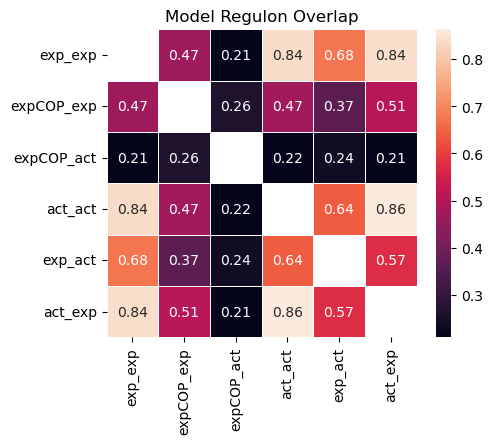

In [194]:
import numpy as np
import pandas as pd

# Extract interactions as sets per model
model_interactions = {model: set(regulons_all[model].keys()) for model in regulons_all}

# Initialize an empty matrix
overlap_matrix = np.zeros((len(models), len(models)))

# Calculate pairwise overlaps (e.g., Jaccard index or intersection size)
for i, model1 in enumerate(models):
    for j, model2 in enumerate(models):
        if i <= j:  # Only calculate once per pair
            set1 = model_interactions[model1]
            set2 = model_interactions[model2]
            
            # Jaccard index: Intersection / Union
            intersection_size = len(set1 & set2)
            union_size = len(set1 | set2)
            overlap = intersection_size / union_size if union_size > 0 else 0

            # Store the overlap in the matrix (symmetric)
            overlap_matrix[i][j] = overlap
            overlap_matrix[j][i] = overlap

# Convert to a pandas DataFrame for easier visualization
overlap_df = pd.DataFrame(overlap_matrix, index=models, columns=models)

# Display the matrix nicely
print(overlap_df.round(3))

plt.figure(figsize=(5, 4))
mask = np.eye(len(models), dtype=bool)  # Mask to grey-out the diagonal
sns.heatmap(overlap_df, annot=True,  mask=mask, linewidths=0.5)#, cmap="Blues",
plt.title("Model Regulon Overlap")
plt.show()


            exp_exp  expCOP_exp  expCOP_act  act_act  exp_act  act_exp
exp_exp       1.000       0.027       0.014    0.041    0.064    0.053
expCOP_exp    0.027       1.000       0.056    0.009    0.014    0.011
expCOP_act    0.014       0.056       1.000    0.020    0.033    0.010
act_act       0.041       0.009       0.020    1.000    0.098    0.058
exp_act       0.064       0.014       0.033    0.098    1.000    0.039
act_exp       0.053       0.011       0.010    0.058    0.039    1.000


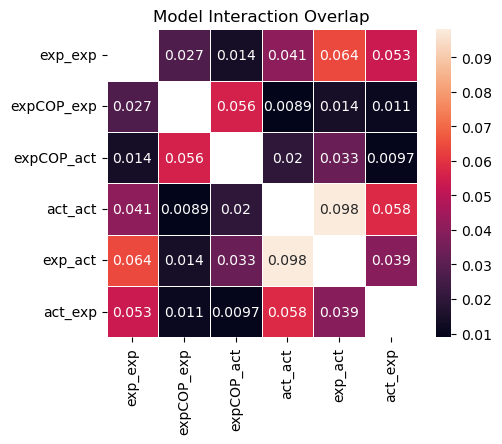

In [193]:
import numpy as np
import pandas as pd

# Extract interactions as sets per model
model_interactions = {model: set(interactions_all[model].keys()) for model in interactions_all}

# Initialize an empty matrix
overlap_matrix = np.zeros((len(models), len(models)))

# Calculate pairwise overlaps (e.g., Jaccard index or intersection size)
for i, model1 in enumerate(models):
    for j, model2 in enumerate(models):
        if i <= j:  # Only calculate once per pair
            set1 = model_interactions[model1]
            set2 = model_interactions[model2]
            
            # Jaccard index: Intersection / Union
            intersection_size = len(set1 & set2)
            union_size = len(set1 | set2)
            overlap = intersection_size / union_size if union_size > 0 else 0

            # Store the overlap in the matrix (symmetric)
            overlap_matrix[i][j] = overlap
            overlap_matrix[j][i] = overlap

# Convert to a pandas DataFrame for easier visualization
overlap_df = pd.DataFrame(overlap_matrix, index=models, columns=models)

# Display the matrix nicely
print(overlap_df.round(3))

plt.figure(figsize=(5, 4))
mask = np.eye(len(models), dtype=bool)  # Mask to grey-out the diagonal
sns.heatmap(overlap_df, annot=True,mask=mask, linewidths=0.5) #   cmap="Blues", 
plt.title("Model Interaction Overlap")
plt.show()
# expectation value:  < 0.004

In [90]:
# Generate summary statistics for regulons_all
summary_data = []
for model, regulons in regulons_all.items():
    num_tfs = len(regulons)
    num_tgs = len(set(tg for tf in regulons for tg in regulons[tf]))
    regulon_sizes = [len(regulon) for regulon in regulons.values()]
    mean_size = np.mean(regulon_sizes)
    median_size = np.median(regulon_sizes)
    
    summary_data.append([model, num_tfs, num_tgs, mean_size, median_size])

# Create a DataFrame to display the summary
summary_df = pd.DataFrame(summary_data, columns=["Model", "# TFs", "# TGs", "Mean Regulon Size", "Median Regulon Size"])
summary_df

Model  # TFs  # TGs  Mean Regulon Size  Median Regulon Size
0     exp_exp    421  11932         117.451306                 46.0
1  expCOP_exp    482   5441         101.821577                 32.0
2  expCOP_act    178   6575         277.084270                 58.0
3     act_act    305  11922         161.701639                 50.0
4     exp_act    347  12050         142.046110                 31.0
5     act_exp    513  11885          97.115010                 55.0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0]
2177


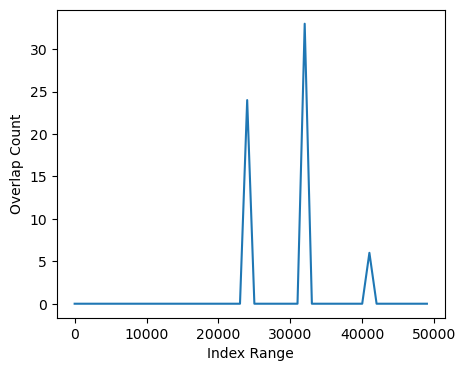

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

overlap_pct = []
x_label = []
step = 1000
model1 = 'exp_exp'
model2 = 'expCOP_exp'

# Get keys for both models
model1_keys = list(interactions_all[model1].keys())
model2_keys = list(interactions_all[model2].keys())

# Ensure we're comparing the same set of keys
min_len = min(len(model1_keys), len(model2_keys))

for i in range(0, min_len, step):
    overlap = len(set(model1_keys[i:i + step]).intersection(set(model2_keys[i:i + step])))
    overlap_pct.append(overlap)
    x_label.append(i)  # or you could use (i + step) for the upper range of the bin

print(overlap_pct)
print(len(set(model1_keys).intersection(set(model2_keys))))

# Plot
plt.figure(figsize=(5, 4))
sns.lineplot(y=overlap_pct, x=x_label)
plt.xlabel('Index Range')  # Add a label to the x-axis for clarity
plt.ylabel('Overlap Count')
plt.show()


In [108]:
# set up CollecTRI Bencjmark
path_CTRI            = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/22JLR_ATAC_GRN_benchmark/GBM/omnipath/CollecTri_gene_names.csv'
CTRI_full, CTRI_full_filtered = prepareCollecTRIGoldStandard(path_CTRI, evidence_score=1)

In [109]:
# Benchmark
# Now validate precision, recall and TP fraction per sample for different top k edges
# This can take a couple of minutes ! Relax and drink a coffee
# My early recall contains a logic error:
#       It works only because all of SCENICs scores are applied, also to the onces that scenic pruned with cis target.\
#       It therefore indicates the 'recall loss' due to the pruning of scenic, but not a recall
rc_sample_10x              = []
pc_sample_10x              = []
early_rc_sample_10x        = []
checked_range_sample_10x   = []

# all interactions in gold standard
no_interactions_CTRI = sum([sum(CTRI_full[x]['Status']) for x in CTRI_full])
samples = models
# Calculations for 10x
for sample in samples:
    print('10x', sample)
    # Concatenate all regulons, and prepare them vor validation against the gold standard
    a1 = pd.concat(TF_TG_interactions_binary_all[sample].values())
    a2 = pd.concat(TF_TG_interactions_weighted_all[sample].values())    
    b1 = pd.concat(CTRI_full.values()) 
    I_TG_b, I_Gold = intersect_pf(a1, b1)
    I_TG_w, I_Gold = intersect_pf(a2, b1)
    y_true  = np.array(I_Gold['Status'])
    y_pred  = np.array(I_TG_b['Status'])
    weights = np.array(I_TG_w['Status'])
    # Before sorting, we need to set all non-interaction values to zero !! Important to not bias SCENIC
    for i in range(len(weights)):
        if y_pred[i] == 0:
            weights[i] = 0
    # sort all interactions by the weight of their interactions
    list1, list2, list3 = zip(*sorted(zip(weights, y_true, y_pred), reverse=True))

    rc                = []
    pc                = []
    early_rc          = []
    checked_range_10x = []
    for i in [100,300,500,1000,3000,5000,10000,30000]:#,50000, len(list3)]:
        list3_filtered =   np.array(list(list3[0:i])+list(np.zeros(len(list3)-i)))         
        #rc.append(sk.metrics.recall_score(list2, list3_filtered))
        pc.append(sk.metrics.precision_score(list2, list3_filtered))    
        # Since the recall is artificially small: Percentage of Found interactions in top k edges
        early_rc.append(sk.metrics.confusion_matrix(list2, list3_filtered)[1,1]/sum(list2[0:i]))
        # Lets try a less biased version of recall: (problem: number of interaction is different between 10x and SMS)
        rc.append(sk.metrics.confusion_matrix(list2, list3_filtered)[1,1] / no_interactions_CTRI)
        
        
        checked_range_10x.append(i)
    rc_sample_10x.append(rc)
    pc_sample_10x.append(pc)
    early_rc_sample_10x.append(early_rc)
    checked_range_sample_10x.append(checked_range_10x)
    

10x exp_exp
10x expCOP_exp
10x expCOP_act
10x act_act
10x exp_act
10x act_exp


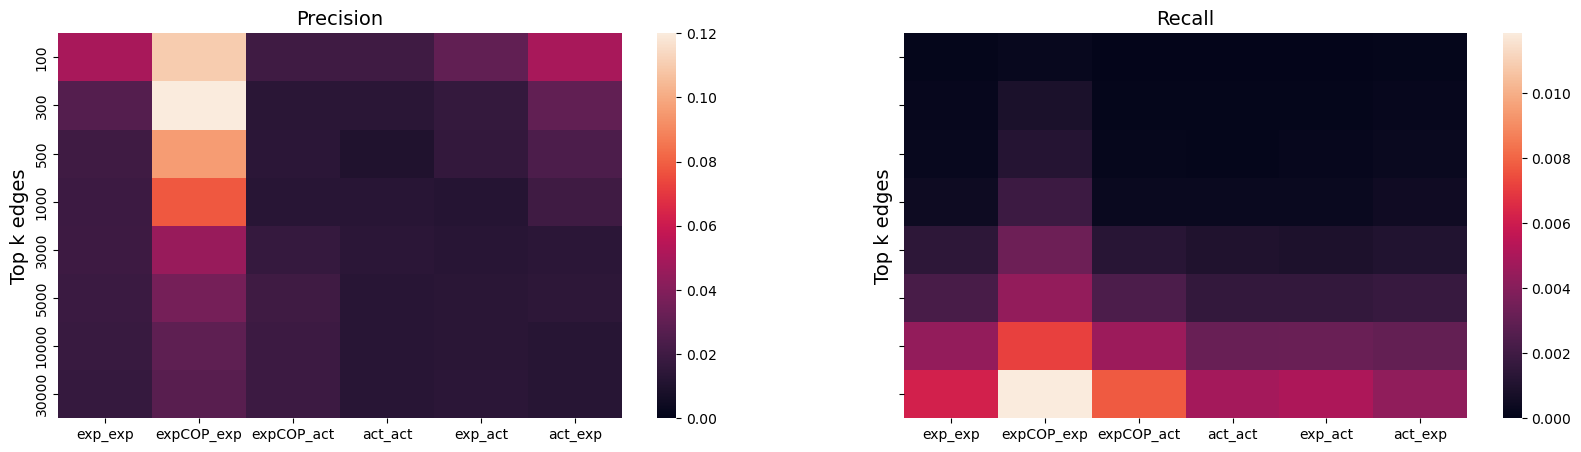

In [110]:
# Visualize benchmark results as heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
plt.subplots_adjust(hspace=0.5)

# Convert samples into a flexible DataFrame structure
df = pd.DataFrame({sample: pc_sample_10x[i] for i, sample in enumerate(samples)})
df2 = pd.DataFrame({sample: rc_sample_10x[i] for i, sample in enumerate(samples)})

# Set titles
axes[0].set_title("Precision", fontsize=14)
axes[1].set_title("Recall", fontsize=14)

# Define y-axis labels
yticks = [100, 300, 500, 1000, 3000, 5000, 10000, 30000]

# Plot heatmaps
sns.heatmap(df, yticklabels=yticks, ax=axes[0], vmin=0)
sns.heatmap(df2, yticklabels=yticks, ax=axes[1], vmin=0)

# Set y-labels
axes[0].set_ylabel('Top k edges', rotation='vertical', fontsize=14)
axes[1].set_ylabel('Top k edges', rotation='vertical', fontsize=14)

# Save figures (if needed)
# fig.savefig(result_folder + 'Benchmark_full_network_precision_recall.png', dpi=300, format='png')
# fig.savefig(result_folder + 'Benchmark_full_network_precision_recall.svg', dpi=300, format='svg')

plt.show()

In [107]:
# Calculate Activities for networks
all_activity_matrices = {}
for sample in models:
    print(sample)
    net = regulons_all[sample]
        
    outfile = open(path_to_signature+'/'+sample+'_singatures.tsv', 'w')
    for regulator in net:
        targets = list(net[regulator].keys())
        outfile.write(generateSignature(regulator, targets)+'\n')
    outfile.close()

    # import sigantures
    signatures = GeneSignature.from_gmt(path_to_signature+'/'+sample+'_singatures.tsv', field_separator='\t', gene_separator='\t')
    print(len(signatures))
    
    # Check some percentiles => or simply use default of 0.05 as cut-off
    percentiles = derive_auc_threshold(ex_matrix)
    percentiles

    # Calculate AUCell
    print(ex_matrix.shape)
    aucs_mtx = aucell(ex_matrix, signatures, auc_threshold=0.05, seed=250, num_workers=4)
    all_activity_matrices[sample] = aucs_mtx
    print(aucs_mtx.shape)
    #print(aucs_mtx.head())

    # # export
    #aucs_mtx.T.to_csv('/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/run_2/models_pruned/regulon_activity_AUCell'+sample+'regulon_activity.csv')

    # # Calculate thresholds 
    # thresholds = binarize(aucs_mtx.T.values, seed=43, num_workers=3, method="hdt")
    # pd.DataFrame({'regulon': list(aucs_mtx.columns) , 'thresholds':list(thresholds)}).to_csv(path_to_thresholds, index=False)

    # # Create binary matrix
    # bin_mat = pd.DataFrame(aucs_mtx.T.values > thresholds.values.reshape(-1,1), dtype=int)
    # bin_mat.index = aucs_mtx.T.index
    # bin_mat.columns = aucs_mtx.T.columns
    # bin_mat.to_csv(path_to_binarization)



exp_exp
421
(9212, 26327)
(9212, 421)
expCOP_exp
482
(9212, 26327)
(9212, 482)
expCOP_act
178
(9212, 26327)
(9212, 178)
act_act
305
(9212, 26327)
(9212, 305)
exp_act
347
(9212, 26327)
(9212, 347)
act_exp
513
(9212, 26327)
(9212, 513)


Cell
AAACAGCCAATCCCTT-1    CD4+ T activated
AAACAGCCACACTAAT-1        CD4+ T naive
AAACAGCCACCAACCG-1        CD4+ T naive
AAACAGCCAGGATAAC-1        CD4+ T naive
AAACAGCCAGTTTACG-1    CD4+ T activated
                            ...       
TTTGTTGGTGTTAAAC-1        CD4+ T naive
TTTGTTGGTTAGGATT-1                  NK
TTTGTTGGTTGCAGTA-1    CD4+ T activated
TTTGTTGGTTGGTTAG-1    CD4+ T activated
TTTGTTGGTTTGCAGA-1    CD4+ T activated
Name: manual_celltype_annotation, Length: 9212, dtype: category
Categories (7, object): ['B cells', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ cytotoxic T', 'Monocytes', 'NK', 'pDC']


/apps/gent/RHEL9/zen2-ib/software/Seaborn/0.13.2-gfbf-2023a/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/apps/gent/RHEL9/zen2-ib/software/Seaborn/0.13.2-gfbf-2023a/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


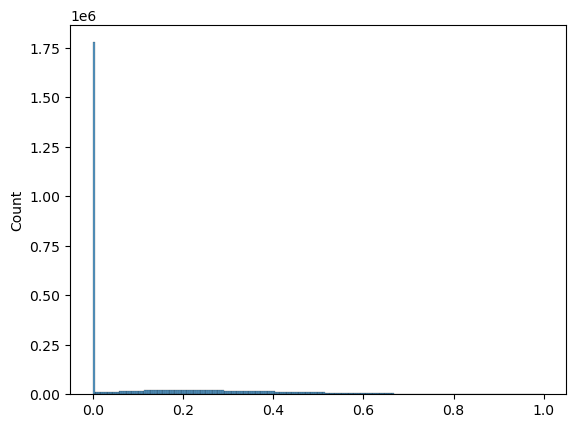

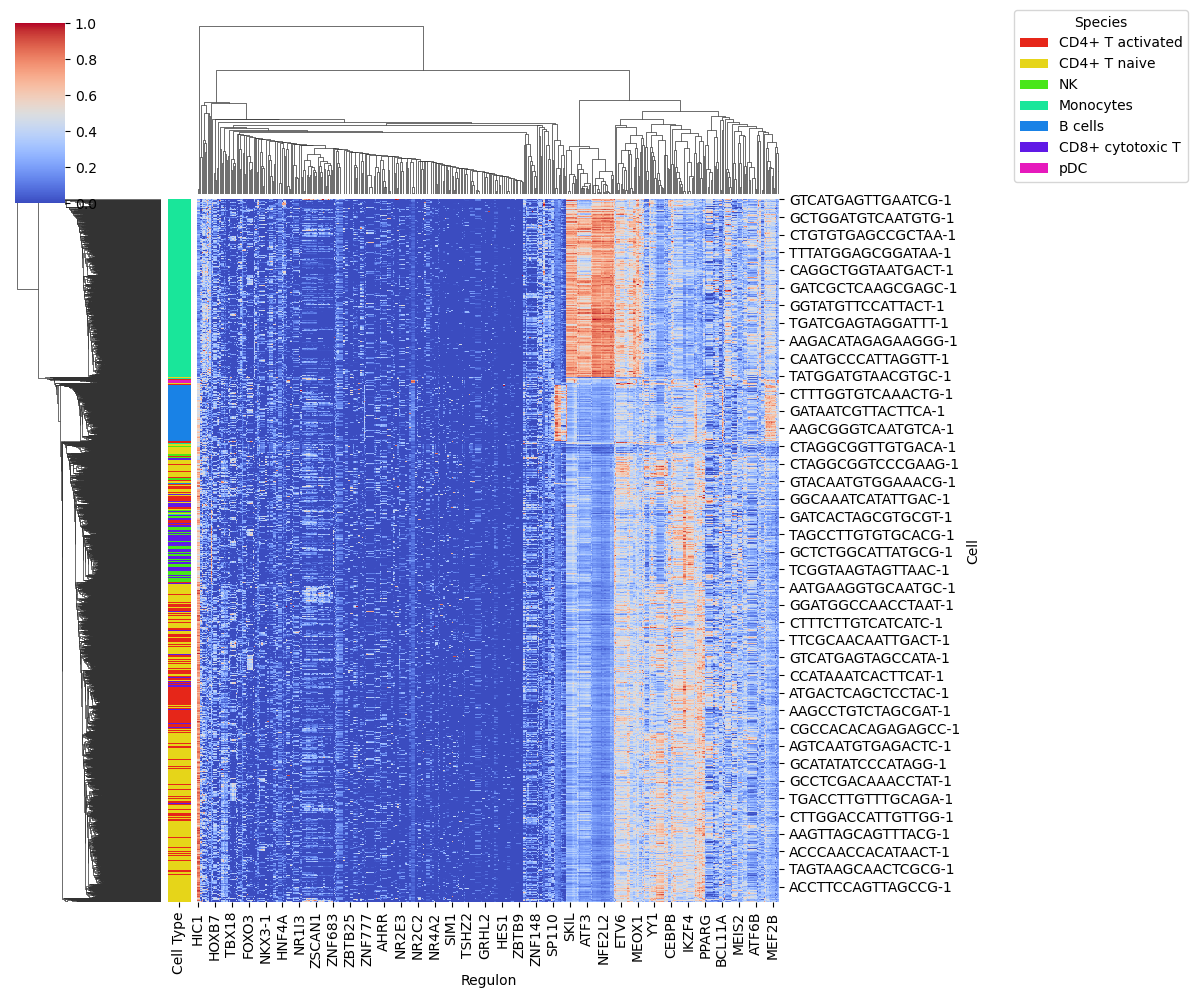

In [112]:
sample = 'expCOP_exp'
# pf     = '10x'
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
# Standard clustering

matrix = all_activity_matrices[sample]

for regulon in matrix:
    min_val = min(matrix[regulon])
    max_val = max(matrix[regulon])
    matrix[regulon] = (matrix[regulon] - min_val) / (max_val - min_val)

%matplotlib inline
matrix = all_activity_matrices[sample]
sns.histplot(matrix.values.flatten())

labels = adata_annotation.obs['manual_celltype_annotation']
print(labels)
labels.index=matrix.index

s = []
#lut      = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
lut      = dict(zip(['CD4+ T activated', 'CD4+ T naive', 'NK', 'Monocytes', 'B cells', 'CD8+ cytotoxic T',   'pDC'], sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
#lut      = dict(zip(['NPC', 'unknown', 'MES', 'AC', 'OPC'], sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
for i in pd.DataFrame(labels)['manual_celltype_annotation']:
    s.append(lut[i])
    #print(lut[i])
row_colors = pd.Series(s)
row_colors.index = matrix.index

combined_row_colors       = pd.DataFrame({'Cell Type': row_colors})#, 'Clusters': cluster_colors})
combined_row_colors.index = matrix.index

g=sns.clustermap(matrix, col_cluster=True, row_cluster=True, cmap='coolwarm', row_colors=combined_row_colors)

#print("Clusters:", len(set(clusters)))


handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Species',
           bbox_to_anchor=(1.2, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

# Get row and column ordering from the clustermap
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# # Reorder the matrix
# clustered_matrix = matrix.iloc[row_order, col_order]
# clustered_matrices['exp_exp_GE'] = clustered_matrix

plt.show()

In [114]:
all_mean_scores             = {}
all_mean_scores_by_celltype = {}
overall_sc                  = {}

for assay_type in all_activity_matrices.keys():
    print(assay_type)
    X     = np.array(all_activity_matrices[assay_type])
    X_scaled = StandardScaler().fit_transform(X)
    pca   = PCA(n_components=7)

    X_pca = pca.fit_transform(X_scaled)
    X = pdist(X_pca, metric='euclidean')
    X= squareform(X)  # Convert for easy indexing
    labels = np.array(adata_annotation.obs['manual_celltype_annotation'])  # Two clusters (0 and 1)
    
    # Compute overall silhouette score
    overall_silhouette = silhouette_score(X, labels, metric='precomputed')
    print(f"Overall Silhouette Score: {overall_silhouette:.3f}")
    overall_sc[assay_type] = overall_silhouette
    # Compute silhouette scores per sample
    sample_silhouette_values = silhouette_samples(X, labels,  metric='precomputed')

    new_row = pd.DataFrame({
    "Label": ["score"],
    "Silhouette Score": [overall_silhouette]
    })
    
    # Compute mean silhouette score per label
    silhouette_per_label = pd.DataFrame({"Label": labels, "Silhouette Score": sample_silhouette_values})
    silhouette_per_label = pd.concat([silhouette_per_label, new_row], ignore_index=True)
    
    mean_silhouette_per_label = silhouette_per_label.groupby("Label")["Silhouette Score"].mean()
    all_mean_scores[assay_type] = overall_silhouette
    print("\nSilhouette Score Per Label:")
    print(mean_silhouette_per_label)
    all_mean_scores_by_celltype[assay_type] = mean_silhouette_per_label

exp_exp
Overall Silhouette Score: 0.247

Silhouette Score Per Label:
Label
B cells             0.446896
CD4+ T activated    0.076362
CD4+ T naive        0.097121
CD8+ cytotoxic T    0.022589
Monocytes           0.607826
NK                  0.088627
pDC                 0.577495
score               0.247359
Name: Silhouette Score, dtype: float64
expCOP_exp
Overall Silhouette Score: 0.157

Silhouette Score Per Label:
Label
B cells             0.130500
CD4+ T activated    0.017872
CD4+ T naive        0.059232
CD8+ cytotoxic T   -0.016902
Monocytes           0.482184
NK                  0.021456
pDC                 0.207034
score               0.157388
Name: Silhouette Score, dtype: float64
expCOP_act
Overall Silhouette Score: 0.097

Silhouette Score Per Label:
Label
B cells             0.167021
CD4+ T activated   -0.010773
CD4+ T naive       -0.003468
CD8+ cytotoxic T   -0.010053
Monocytes           0.344250
NK                 -0.017964
pDC                 0.111147
score               0.09

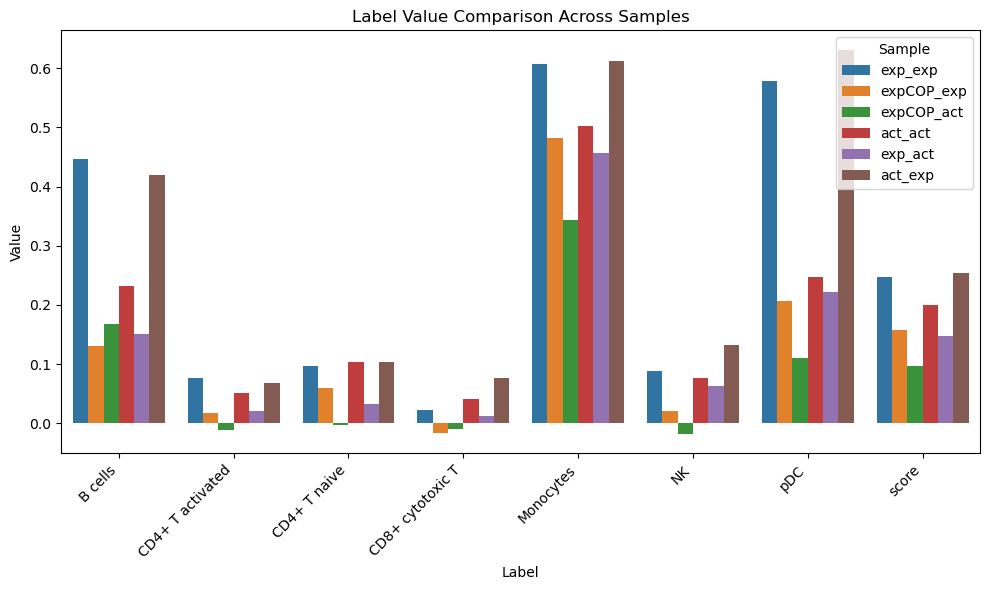

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example dictionary of arrays

# Convert the dictionary to a DataFrame in long format
df = pd.DataFrame(all_mean_scores_by_celltype).T
df.reset_index(inplace=True)
df = df.melt(id_vars='index', value_vars=df.columns[1:], 
             var_name='Label', value_name='Value')

# Rename 'index' to 'Sample' for better understanding
df.rename(columns={'index': 'Sample'}, inplace=True)

# Create the barplot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Label', y='Value', hue='Sample', data=df)

# Customize plot
plt.xticks(rotation=45, ha='right')
plt.title('Label Value Comparison Across Samples')
plt.tight_layout()
plt.show()


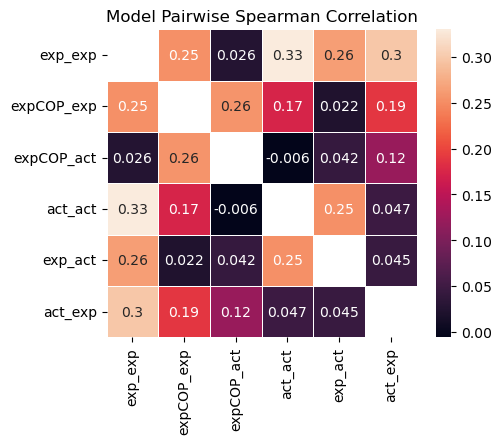

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

# Prepare a list to store the pairwise Spearman correlations for each model
models = list(all_activity_matrices.keys())
spearman_matrix = np.zeros((len(models), len(models)))

# Loop over all pairs of models
for i in range(len(models)):
    for j in range(i + 1, len(models)):  # Ensure unique pairs
        model1 = models[i]
        model2 = models[j]
        
        # Collect the activity values from both models for each sample
        for sample in samples:  # Assuming 'samples' is a list of sample names
            activity1 = all_activity_matrices[model1]
            activity2 = all_activity_matrices[model2]
            
            # Find the common regulons
            shared_regulons = list(set(activity1.columns).intersection(activity2.columns))
            
            # Extract the values for the shared regulons
            scores_model1 = activity1[shared_regulons].mean(axis=0)
            scores_model2 = activity2[shared_regulons].mean(axis=0)
            
            # Calculate the Spearman correlation
            spearman_coeff, _ = scipy.stats.spearmanr(scores_model1, scores_model2)
            
            # Store the Spearman coefficient in the matrix
            spearman_matrix[i, j] = spearman_coeff
            spearman_matrix[j, i] = spearman_coeff  # Symmetric matrix

# Convert the matrix to a DataFrame for easier handling with Seaborn
spearman_df = pd.DataFrame(spearman_matrix, index=models, columns=models)

# Create the heatmap
plt.figure(figsize=(5, 4))
mask = np.eye(len(models), dtype=bool)  # Mask to grey-out the diagonal
sns.heatmap(spearman_df, annot=True, mask=mask, linewidths=0.5)
plt.title("Model Pairwise Spearman Correlation")
plt.show()


In [128]:
spearman_df

exp_exp  expCOP_exp  expCOP_act   act_act   exp_act   act_exp
exp_exp     0.000000    0.253104    0.025792  0.329991  0.263667  0.298488
expCOP_exp  0.253104    0.000000    0.255664  0.173269  0.021893  0.188514
expCOP_act  0.025792    0.255664    0.000000 -0.006005  0.041642  0.121487
act_act     0.329991    0.173269   -0.006005  0.000000  0.253766  0.047008
exp_act     0.263667    0.021893    0.041642  0.253766  0.000000  0.044748
act_exp     0.298488    0.188514    0.121487  0.047008  0.044748  0.000000

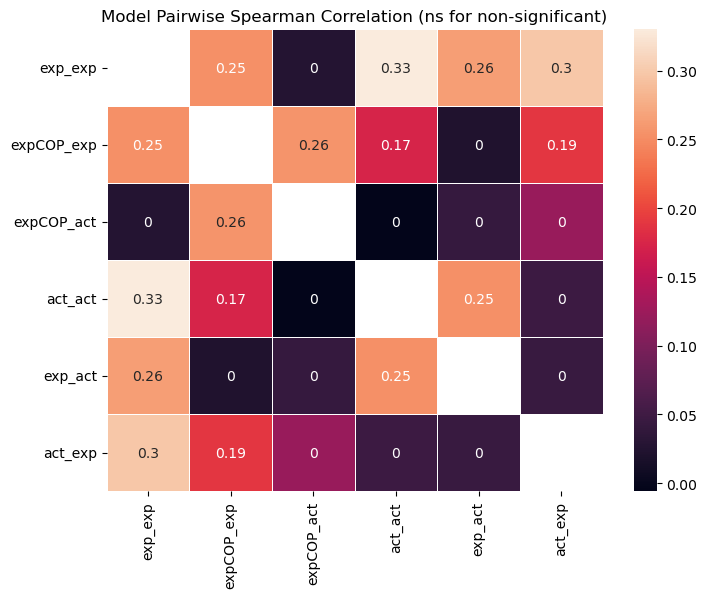

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import numpy as np

# Prepare a list to store the pairwise Spearman correlations for each model
models = list(all_activity_matrices.keys())
spearman_matrix = np.zeros((len(models), len(models)))
p_value_matrix = np.ones((len(models), len(models)))  # Store p-values

# Loop over all pairs of models
for i in range(len(models)):
    for j in range(i + 1, len(models)):  # Ensure unique pairs
        model1 = models[i]
        model2 = models[j]
        
        # Collect the activity values from both models for each sample
        for sample in samples:  # Assuming 'samples' is a list of sample names
            activity1 = all_activity_matrices[model1]
            activity2 = all_activity_matrices[model2]
            
            # Find the common regulons
            shared_regulons = list(set(activity1.columns).intersection(activity2.columns))
            
            # Extract the values for the shared regulons
            scores_model1 = activity1[shared_regulons].mean(axis=0)
            scores_model2 = activity2[shared_regulons].mean(axis=0)
            
            # Calculate the Spearman correlation and p-value
            spearman_coeff, p_value = scipy.stats.spearmanr(scores_model1, scores_model2)
            
            # Store the Spearman coefficient in the matrix
            spearman_matrix[i, j] = spearman_coeff
            spearman_matrix[j, i] = spearman_coeff  # Symmetric matrix
            
            # Store the p-value in the p-value matrix
            p_value_matrix[i, j] = p_value
            p_value_matrix[j, i] = p_value  # Symmetric matrix

# Convert the matrix to a DataFrame for easier handling with Seaborn
spearman_df = pd.DataFrame(spearman_matrix, index=models, columns=models)
p_value_df = pd.DataFrame(p_value_matrix, index=models, columns=models)

# Create a new matrix to store the labels (Spearman values or 'ns')
label_matrix = spearman_df.copy()

# Replace Spearman coefficients with 'ns' where p-value > 0.05
for i in range(len(models)):
    for j in range(len(models)):
        if p_value_df.iloc[i, j] > 0.05:
            label_matrix.iloc[i, j] = 0

# Create the heatmap
plt.figure(figsize=(8, 6))
mask = np.eye(len(models), dtype=bool)  # Mask to grey-out the diagonal
sns.heatmap(spearman_df, annot=label_matrix, mask=mask, linewidths=0.5)
plt.title("Model Pairwise Spearman Correlation (ns for non-significant)")
plt.show()


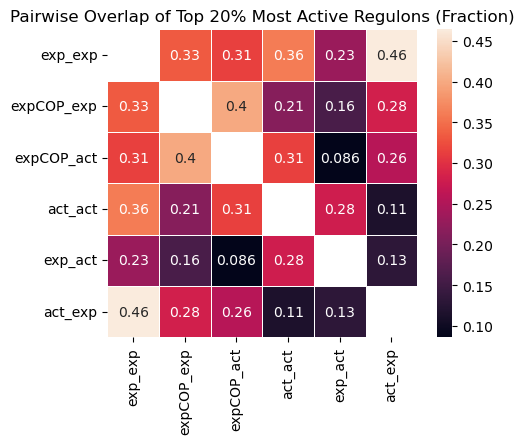

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set the percentage cutoff for the top N most active regulons (e.g., 0.2 for 20%)
top_n_overlap_thres = 0.2  # You can change this to any other value like 0.1 for 10%

# Prepare a list to store the overlap for each pair of models
models = list(all_activity_matrices.keys())
overlap_matrix = np.zeros((len(models), len(models)))

# Loop over all pairs of models
for i in range(len(models)):
    for j in range(i + 1, len(models)):  # Ensure unique pairs
        model1 = models[i]
        model2 = models[j]
        
        # Collect the activity values from both models for each sample
        for sample in samples:  # Assuming 'samples' is a list of sample names
            activity1 = all_activity_matrices[model1]
            activity2 = all_activity_matrices[model2]
            
            # Get the top N% most active regulons for each model based on the threshold
            top_n_model1 = activity1.mean(axis=0).nlargest(int(len(activity1.columns) * top_n_overlap_thres)).index
            top_n_model2 = activity2.mean(axis=0).nlargest(int(len(activity2.columns) * top_n_overlap_thres)).index
            
            # Calculate the overlap of the top N% regulons
            overlap = len(set(top_n_model1).intersection(set(top_n_model2)))
            
            # Calculate the fraction of overlap with respect to the top N% regulons of the models
            fraction_overlap = overlap / min(len(top_n_model1), len(top_n_model2))
            
            # Store the fraction of overlap in the matrix
            overlap_matrix[i, j] = fraction_overlap
            overlap_matrix[j, i] = fraction_overlap  # Symmetric matrix

# Convert the matrix to a DataFrame for easier handling with Seaborn
overlap_df = pd.DataFrame(overlap_matrix, index=models, columns=models)

# Create the heatmap
plt.figure(figsize=(5, 4))
mask = np.eye(len(models), dtype=bool)  # Mask to grey-out the diagonal
sns.heatmap(overlap_df, annot=True, mask=mask, linewidths=0.5)
plt.title(f"Pairwise Overlap of Top {int(top_n_overlap_thres * 100)}% Most Active Regulons (Fraction)")
plt.show()


# Chapter 2: Comparison of the integdated networks and their benefits
I will try to make chapters autark and independend from each other, so that I can later start adapting one without influencing the other. Moreover, all results will be saved then under a specific folder 

# Chapter 3: The influence of model performance on the GRN
- Show how model performance is distributed, and what meta-data variables correlate with bad performance
- Show how ‘edge stability’ is nicely correlated to the TFs with the highest scores

In [79]:
# Folder set-up
result_folder_1       = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/thesis_chapters/chapter_1/'
path_to_expression    = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/data/human_PBMC_10x_10k/pbmc_granulocyte_sorted_10k_gex_molecule_info_filtered_mg_mc_gc_mt_tc.h5ad'#'/scratch/gent/vo/000/gvo00027/projects/CBIGR/25MDT_PBMC_10xmultiome/PBMC_manual_anno_Jens/pbmc_granulocyte_sorted_10k_gex_molecule_info_manual_annotation.h5ad'
path_to_geneactivity  = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/PBMC10k_gene_activity_matrix.h5ad'#'/scratch/gent/vo/000/gvo00027/projects/CBIGR/25MDT_PBMC_10xmultiome/PBMC_manual_anno_Jens/pbmc_granulocyte_sorted_10k_gex_molecule_info_manual_annotation.h5ad'
path_to_signature     = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/run_2/models_pruned/gene_signatures_AUCell/'
path_to_regulons      = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/run_2/models_pruned/'
get_annotation_adata  = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/25MDT_PBMC_10xmultiome/PBMC_manual_anno_Jens/pbmc_granulocyte_sorted_10k_gex_molecule_info_manual_annotation.h5ad'

models = ['exp_exp', 'expCOP_exp',  'expCOP_act', 'expCOP_act',  'actCOP_exp', 'act_act', 'exp_act', 'act_exp']

In [80]:
adata_annotation = sc.read_h5ad( get_annotation_adata)
adata = sc.read_h5ad( path_to_expression)
adata_filtered = adata[adata.obs.index.isin(adata_annotation.obs_names)].copy()
ex_matrix = pd.DataFrame(data = adata_filtered.X.toarray(), index=adata_filtered.obs_names, columns=adata_filtered.var_names)
geneactivity_adata = sc.read_h5ad(path_to_geneactivity)

In [58]:
# lets start with loading the XGBoost outputs first

# set up pathes
base_result_path = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/'
run_name         = 'run_2/'
models = ['exp_exp', 'expCOP_exp',  'expCOP_act', 'act_act', 'exp_act', 'act_exp']

# Define data structure
TG_models_scores            = {}
TG_models_rank_deviation    = {}
TG_models_evals             = {}
TG_models_pred_performance  = {}

# load results: adapt ranges towards how the model was split
for m in models:

    path = base_result_path+run_name+'/model_'+ m + '/'

    # load scores
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_scores.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_scores:
                TG_models_scores[m] = scores
            else:
                TG_models_scores[m].update(scores)
                
    # load rank deviations
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_scores_rank_deviation.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_rank_deviation:
                TG_models_rank_deviation[m] = scores
            else:
                TG_models_rank_deviation[m].update(scores)
                
    # load model evals
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_evals.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_evals:
                TG_models_evals[m] = scores
            else:
                TG_models_evals[m].update(scores)        
                
    # load model performacnce
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_predictive_performance.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_pred_performance:
                TG_models_pred_performance[m] = scores
            else:
                TG_models_pred_performance[m].update(scores) 


In [50]:
# make networks
k            = 10
n_edges      = 50000
min_reg_size = 10
filter_TGs   = None

regulons_all                    = {}
interactions_all                = {}
TF_TG_interactions_binary_all   = {}
TF_TG_interactions_weighted_all = {}

# create the desiderd networks
for model in models:
    print(model)
    new_scores     = normalizeImportanceScores(TG_models_scores[model], top_k_threshold=k)
    if "COP" in model:
        print('COP detected')
        new_scores     = delineateComplexScores(TG_models_scores[model])
    new_scores_all = normalizeForModelPerformance(new_scores, TG_models_pred_performance[model])
    regulons_all[model], interactions_all[model], TF_TG_interactions_binary_all[model], TF_TG_interactions_weighted_all[model] = makeCustomNetwork(new_scores_all, minimum_regulon_size=min_reg_size, number_edges=n_edges, filter_TGs=filter_TGs, verbose=False)

exp_exp
expCOP_exp
COP detected
expCOP_act
COP detected
act_act
exp_act
act_exp


In [59]:
# (model.data_mean, model.train_mae, model.test_mae, model.test_mae_std, model.train_mae_std)

all_model_performance_mean              = {}
all_model_performance_mae_train         = {}
all_model_performance_mae_test          = {}
all_model_performance_mean_mae_ratio    = {}
all_model_performance_train_test_ratio  = {}
all_models_bad_TGs                      = {}
all_models_good_TGs                     = {}
all_models_medium_TGs                   = {}

for model in models:
    model_mean  = []
    model_test  = []
    model_train = []
    mean_train  = []
    train_test  = []
    bad_TGs     = []
    none_model  = []
    good_TGs    = []
    medium_TGs  = []
    for TG_model in TG_models_pred_performance[model]:
        #print(TG_models_pred_performance[model][TG_model])
        model_mean.append( TG_models_pred_performance[model][TG_model] [0] )
        model_train.append( TG_models_pred_performance[model][TG_model] [1] )
        model_test.append( TG_models_pred_performance[model][TG_model] [1] )
        if TG_models_pred_performance[model][TG_model] [0] > 0:
            mean_train.append( TG_models_pred_performance[model][TG_model] [1] /  TG_models_pred_performance[model][TG_model] [0] )
        else:
            mean_train.append(5)
        if TG_models_pred_performance[model][TG_model] [1] > 0:
            train_test.append( TG_models_pred_performance[model][TG_model] [2] / TG_models_pred_performance[model][TG_model] [1] )
        else:
             train_test.append(5)
        if TG_models_pred_performance[model][TG_model] [0] != 0:      
            if TG_models_pred_performance[model][TG_model] [1] /  TG_models_pred_performance[model][TG_model] [0] > 2.4:
                bad_TGs.append(TG_model)
            if TG_models_pred_performance[model][TG_model] [1] /  TG_models_pred_performance[model][TG_model] [0] < 1 and TG_models_pred_performance[model][TG_model] [0] > 0.005 and TG_models_pred_performance[model][TG_model] [1] > 0.005:
                good_TGs.append(TG_model)
                print(TG_models_pred_performance[model][TG_model] [0], TG_models_pred_performance[model][TG_model] [1])
            if TG_models_pred_performance[model][TG_model] [1] /  TG_models_pred_performance[model][TG_model] [0] > 1 and TG_models_pred_performance[model][TG_model] [1] /  TG_models_pred_performance[model][TG_model] [0] < 2:
                medium_TGs.append(TG_model)
            
#         if TG_models_pred_performance[model][TG_model] [0] == 0:
#             print(TG_models_pred_performance[model][TG_model] [0], TG_models_pred_performance[model][TG_model] [1])
        
    all_model_performance_mean[model]              = model_mean
    all_model_performance_mae_train[model]         = model_train
    all_model_performance_mae_test[model]          = model_test
    all_model_performance_mean_mae_ratio[model]    = mean_train
    all_model_performance_train_test_ratio[model]  = train_test
    all_models_bad_TGs[model]                      = set(bad_TGs)
    all_models_good_TGs[model]                     = set(good_TGs)
    all_models_medium_TGs[model]                   = set(medium_TGs)

5.149153 2.6412578
0.5620929 0.54375345
0.8979592 0.8780367
0.7311116 0.645758
0.9182588 0.90855074
1.0534086 0.9002182
1.141446 0.95480376
1.0943335 0.8887885
3.2920103 2.0927634
0.3813504 0.3394712
0.7917933 0.7908306
5.2250323 2.8166032
4.290925 2.6054468
4.5458097 2.50222
0.6704299 0.66011876
0.9520191 0.91785717
1.3825445 1.0219597
1.5972644 1.0848783
0.50618756 0.4698283
1.8068824 1.2192464
1.3966565 1.083531
1.0105298 0.9474289
1.0604646 0.9846614
1.137538 1.1162708
1.5155232 1.2247987
3.9903388 2.3036857
1.1437256 0.87753713
3.934759 2.2086792
2.753148 1.704253
1.8621364 1.2987444
6.9322624 3.3701901
0.6112679 0.5884587
0.83564913 0.77104294
1.3427051 1.1086597
1.3179549 1.301919
0.9996743 0.91254866
0.8511724 0.81900674
1.5276812 1.1865332
0.055471126 0.042769197
0.7793096 0.75293046
0.8910117 0.87761307
1.2646548 0.9842957
0.83564913 0.82912844
1.311116 0.9823349
0.8295701 0.8131623
20.613981 7.634472
0.35887972 0.3384021
0.8184976 0.81424236
1.474924 1.221806
0.5767477 0.554

0.31958315 0.123431996
0.030720798 0.008426799
1.5698003 1.1785554
0.63547546 0.6241562
1.1707555 0.9270851
1.3145896 1.2140847
7.7187366 3.2144127
0.95853233 0.85223866
0.024099002 0.011065699
0.8589883 0.7253232
1.679657 1.1291296
0.92097265 0.8522333
1.676726 1.357925
1.6983283 1.1388623
0.41033435 0.3119593
0.74229264 0.7309484
0.8813504 0.83247787
0.55666524 0.16098328
0.8647416 0.6212578
0.98360837 0.79648614
3.283543 1.9169861
0.36799827 0.3599716
0.46352583 0.4467779
1.1537125 0.040454373
0.80731654 0.73862666
1.0863005 0.8444357
2.3098133 1.40545
0.6634824 0.57945424
0.29049066 0.007599323
1.0231221 0.85419446
0.05351715 0.045208536
0.30036908 0.2934579
0.22362137 0.04388382
1.0590534 0.9452675
7.2148285 3.608275
5.149153 2.5773106
1.0167173 0.9790803
1.0049934 0.67597234
0.8494355 0.7984375
4.9716673 2.6500354
1.525076 1.0968921
0.8124186 0.43140164
4.290925 2.4563184
0.8206687 0.7362378
0.90002173 0.8651363
1.5470039 1.1330084
6.222753 3.0125434
1.2608554 1.0799872
0.8018888

0.7775465612319218 0.7198895264364005
0.773696805743419 0.7195657835157901
1.3629174903756114 0.9978082649845549
2.2216210592029966 1.2187111504934953
1.070960357923213 0.8977866767348985
1.075954635313703 0.8562065960644116
0.7067942981999792 0.6923783069534771
1.4654042243262928 1.2108968690789548
1.9653522006034752 1.2160570442784642
1.4901675163874726 0.9863661484654674
0.9162418062636563 0.8322627666964874
1.398501716782853 1.0269990320641016
1.800541046717303 1.1331434412982804
0.8300905212777027 0.749808074583725
1.6656955571740715 1.046813836252503
0.9923004890229945 0.8561516723432318
1.5653938195817292 1.1131988594643365
1.043179689938612 0.8922871885089056
0.7517427947143898 0.7362639709250393
1.3256685048382062 0.9705323282227838
0.8992820726251171 0.8555242693673921
0.80147747372802 0.7801433440562662
1.041723025699719 0.8120728779226812
2.1039433981895743 1.1856795845500931
1.1630423473103735 0.8863236532876126
1.8177088752471127 1.1440695941398722
0.7604827801477474 0.74

1.0711986 1.0490327
1.4622338 1.1089653
0.62209016 0.5424534
4.9321446 2.754025
1.1982417 0.9599608
1.3315998 1.0329864
0.9842744 0.82944536
1.5408618 1.1125755
0.9770926 0.89007723
2.466939 1.5988201
3.0771422 1.8531624
1.1918029 1.087321
0.7548291 0.72887266
0.59398216 0.51458806
0.9026746 0.8735412
2.9737494 1.7910082
0.36763248 0.3665914
1.6814017 1.2039372
0.88063395 0.8144654
1.9731302 1.3528078
1.2397226 0.9935214
4.4691677 2.5610225
2.618747 2.0854132
2.1324914 1.3676817
3.0303369 1.6834621
6.6386824 3.3322444
1.1654284 1.0344976
5.6479692 3.00506
2.168524 1.4082533
0.92397225 0.8337914
0.8072065 0.77201873
1.2350173 1.0168706
0.8614413 0.8509921
1.1487123 0.9504191
1.676944 1.1705602
3.60946 2.1071343
0.7996533 0.7953365
1.0094106 0.85776865
7.332962 3.5757961
0.75458145 0.7540475
0.3608222 0.35662138
14.0421 7.2420144
1.6714958 1.3705393
0.8706043 0.7677947
0.81773156 0.78966534
1.0043339 0.94183767
3.9385834 2.432055
0.44737494 0.4290308
0.7383606 0.7175183
1.0527489 0.91387

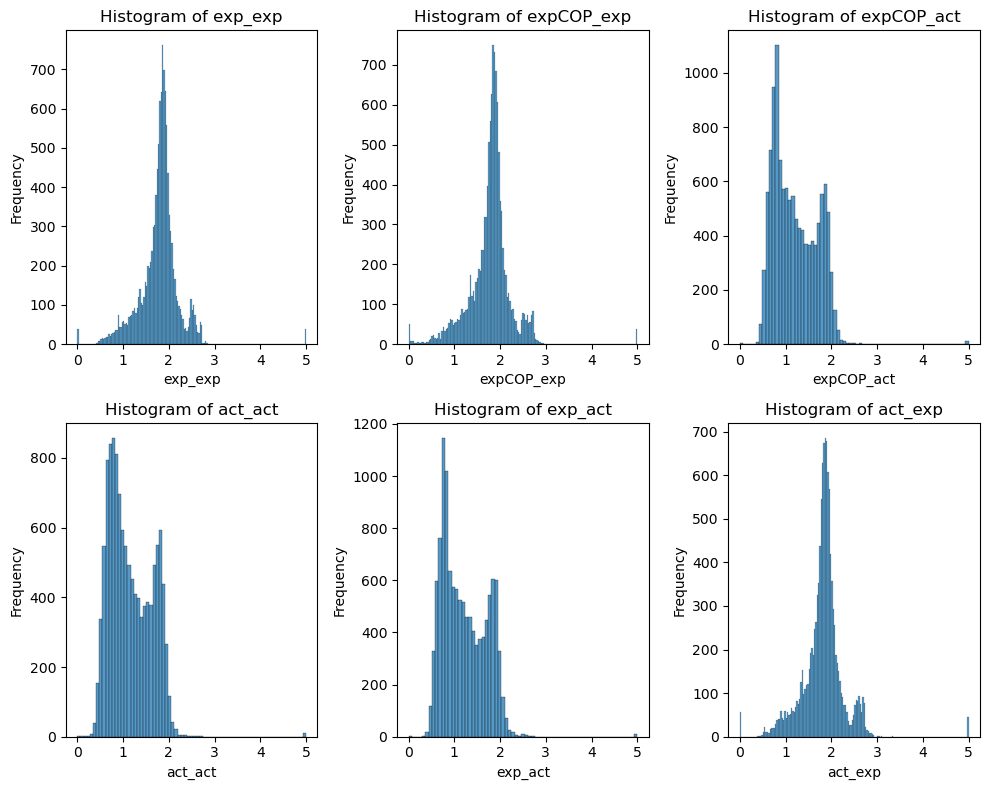

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming all_model_performance_mean_mae_ratio is a dictionary
keys = list(all_model_performance_mean_mae_ratio.keys())

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# Loop over each key in the dictionary and plot
for i, key in enumerate(keys):
    sns.histplot(all_model_performance_mean_mae_ratio[key], ax=axes[i])
    axes[i].set_title(f'Histogram of {key}')
    axes[i].set_xlabel(key)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


In [121]:
# Read the data
adata = sc.read_h5ad(path_to_expression)

model = 'exp_exp'

# Filter observations (cells) based on annotations
adata_filtered = adata[adata.obs.index.isin(adata_annotation.obs_names)].copy()

# Further filter variables (genes) based on TG_models_pred_performance keys
adata_filtered = adata_filtered[:, adata.var.index.isin(list(TG_models_pred_performance[model].keys()))].copy()

desired_gene_order = list(TG_models_pred_performance[model].keys())
adata_filtered = adata_filtered[:, desired_gene_order]


# Convert the filtered AnnData matrix to a DataFrame
ex_matrix_filtered = pd.DataFrame(
    data=adata_filtered.X.toarray(),
    index=adata_filtered.obs_names,
    columns=adata_filtered.var_names
)


In [63]:
adata_filtered.var

gene_ids    feature_types  n_cells_by_counts  mean_counts  \
CD14     ENSG00000170458  Gene Expression               2665     0.402159   
RPS15    ENSG00000115268  Gene Expression              10936     5.900034   
CEP290   ENSG00000198707  Gene Expression               1950     0.234529   
EXOSC9   ENSG00000123737  Gene Expression               1083     0.101581   
TRAJ52   ENSG00000211838  Gene Expression                  3     0.000255   
...                  ...              ...                ...          ...   
THSD7A   ENSG00000005108  Gene Expression                 27     0.004335   
C9       ENSG00000113600  Gene Expression                 10     0.000850   
PON3     ENSG00000105852  Gene Expression                  3     0.000255   
TFCP2L1  ENSG00000115112  Gene Expression                 28     0.002550   
COG5     ENSG00000164597  Gene Expression               7205     1.317239   

         log1p_mean_counts  pct_dropout_by_counts  total_counts  \
CD14              0.335319              77.346141        4731.0   
RPS15             1.923644               7.038422       69408.0   
CEP290            0.208821              83.424005        2759.0   
EXOSC9            0.095937              90.793948        1195.0   
TRAJ52            0.000252              99.974498           3.0   
...                    ...                    ...           ...   
THSD7A            0.004277              99.770486          51.0   
C9                0.000840              99.914995          10.0   
PON3              0.000252              99.974498           3.0   
TFCP2L1           0.002518              99.761986          30.0   
COG5              0.834173              38.753825       15496.0   

         log1p_total_counts  n_cells     mt  
CD14               8.464004     2665  False  
RPS15             11.149873    10936  False  
CEP290             7.924434     1950  False  
EXOSC9             7.089243     1083  False  
TRAJ52             1.386294        3  False  
...                     ...      ...    ...  
THSD7A             3.951244       27  False  
C9                 2.397895       10  False  
PON3               1.386294        3  False  
TFCP2L1            3.433987       28  False  
COG5               9.648788     7205  False  

[12040 rows x 10 columns]

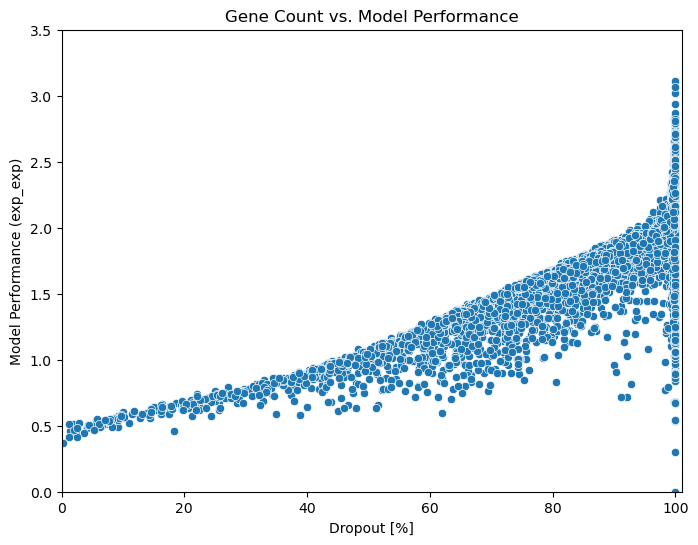

Spearman Correlation: 0.69, p-value: 0.000e+00


In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Extract the values for comparison
x_values = list(adata_filtered.var['pct_dropout_by_counts'])
#y_values = list(all_model_performance_train_test_ratio[model])
y_values = list(all_model_performance_mean_mae_ratio[model])


# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_values, y=y_values)

# sns.kdeplot(
#     x=x_values,
#     y=y_values,
#     fill=True,
#     thresh=0.05,
#     cmap="Blues"
# )
plt.xlabel('Dropout [%]')
plt.ylabel('Model Performance (exp_exp)')
plt.title('Gene Count vs. Model Performance')
#plt.grid(True)
# Custom axis limits
plt.xlim(0,101)  # Customize as needed
plt.ylim(0.0, 3.5)  # Customize as needed
plt.show()

# Spearman correlation test
corr, p_value = spearmanr(x_values, y_values)
print(f"Spearman Correlation: {corr:.2f}, p-value: {p_value:.3e}")


In [90]:
# Read the data
adata = sc.read_h5ad(path_to_geneactivity)

model = 'act_act'

# Filter observations (cells) based on annotations
adata_filtered = adata[adata.obs.index.isin(adata_annotation.obs_names)].copy()

# Further filter variables (genes) based on TG_models_pred_performance keys
adata_filtered = adata_filtered[:, adata.var.index.isin(list(TG_models_pred_performance[model].keys()))].copy()

desired_gene_order = list(TG_models_pred_performance[model].keys())
adata_filtered = adata_filtered[:, desired_gene_order]


# Convert the filtered AnnData matrix to a DataFrame
act_matrix_filtered = pd.DataFrame(
    data=adata_filtered.X.toarray(),
    index=adata_filtered.obs_names,
    columns=adata_filtered.var_names
)


import numpy as np

# Calculate the dropout rate for each feature (gene)
dropout_percentage = np.sum(adata_filtered.X == 0, axis=0) / adata_filtered.shape[0] * 100

# Reshape the dropout percentages to be a column vector
dropout_percentage = dropout_percentage.reshape(-1, 1)

# Create a DataFrame to store the dropout percentage for each feature
dropout_df = pd.DataFrame(
    dropout_percentage,
    index=adata_filtered.var_names,
    columns=['pct_dropout_by_counts']
)

# Sort the DataFrame to see features with the highest dropout percentage
dropout_df = dropout_df.sort_values(by='pct_dropout_by_counts', ascending=False)

adata_filtered.var['pct_dropout_by_counts'] = dropout_percentage

# Display the top 10 features with the highest dropout percentage
#print(dropout_df.head(10))

/apps/gent/RHEL9/zen3x-ib/software/IPython/8.14.0-GCCcore-12.3.0/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_3463801/2719932868.py:42: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_filtered.var['pct_dropout_by_counts'] = dropout_percentage


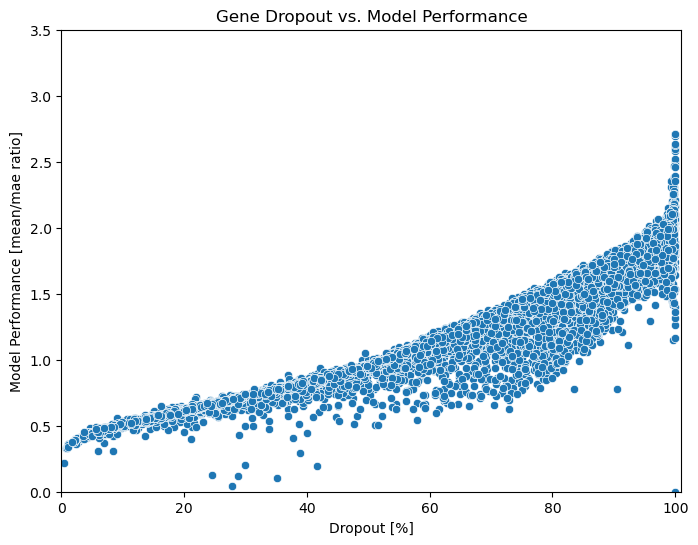

Spearman Correlation: 0.98, p-value: 0.000e+00


In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Extract the values for comparison
x_values = list(adata_filtered.var['pct_dropout_by_counts'])
#y_values = list(all_model_performance_train_test_ratio[model])
y_values = list(all_model_performance_mean_mae_ratio[model])


# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_values, y=y_values)

# sns.kdeplot(
#     x=x_values,
#     y=y_values,
#     fill=True,
#     thresh=0.05,
#     cmap="Blues"
# )
plt.xlabel('Dropout [%]')
plt.ylabel('Model Performance [mean/mae ratio]')
plt.title('Gene Dropout vs. Model Performance')
#plt.grid(True)
# Custom axis limits
plt.xlim(0,101)  # Customize as needed
plt.ylim(0.0, 3.5)  # Customize as needed
plt.show()

# Spearman correlation test
corr, p_value = spearmanr(x_values, y_values)
print(f"Spearman Correlation: {corr:.2f}, p-value: {p_value:.3e}")


In [92]:
# Correlation of expression values 
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Identify common genes
common_genes = set(expression_adata.var_names) & set(geneactivity_adata.var_names)

# Step 2: Filter both AnnData objects
expression_filtered = expression_adata[:, expression_adata.var_names.isin(common_genes)].copy()
geneactivity_filtered = geneactivity_adata[:, geneactivity_adata.var_names.isin(common_genes)].copy()

# Step 3: Compute `log1p_mean_counts` for geneactivity_adata
geneactivity_filtered.var['log1p_mean_counts'] = np.log1p(geneactivity_filtered.X.mean(axis=0).A1)

# Step 4: Prepare a DataFrame for plotting
df = pd.DataFrame({
    'Expression log1p_mean_counts': expression_filtered.var['log1p_mean_counts'],
    'Gene Activity log1p_mean_counts': geneactivity_filtered.var['log1p_mean_counts']
})


# Step 5: Create a density plot
plt.figure(figsize=(6, 6))
sns.kdeplot(data=df, x='Expression log1p_mean_counts', y='Gene Activity log1p_mean_counts', fill=True)

# Set x-axis limits
plt.xlim(0, 1)  # Adjust the range as needed

plt.xlabel('Expression log1p_mean_counts')
plt.ylabel('Gene Activity log1p_mean_counts')
plt.title('Density Plot of log1p_mean_counts (Expression vs. Gene Activity)')
plt.show()

from scipy.stats import spearmanr, pearsonr

print(spearmanr(df['Expression log1p_mean_counts'], df['Gene Activity log1p_mean_counts']))
print(pearsonr(df['Expression log1p_mean_counts'], df['Gene Activity log1p_mean_counts']))

NameError: name 'expression_adata' is not defined

In [ ]:
# now we can classify models into three groups: models with performance < 1, 

In [96]:
TG_models_rank_deviation['exp_exp']

{'CD14': {'CREB5': 0.0,
  'FOS': 0.2222222222222222,
  'CEBPD': 0.8888888888888888,
  'SPI1': 0.8888888888888888,
  'RXRA': 2.0,
  'ETV6': 1.3333333333333333,
  'KLF12': 2.7777777777777777,
  'CUX1': 1.8888888888888888,
  'FOSL1': 5.111111111111111,
  'MEF2A': 6.625,
  'NFIL3': 5.666666666666667,
  'ELF1': 2.125,
  'STAT1': 1.4444444444444444,
  'ATF3': 7.0,
  'FOXN3': 6.375,
  'JUN': 5.25,
  'ETV7': 8.0,
  'CEBPA': 8.0,
  'STAT2': 4.222222222222222,
  'MEF2C': 3.5,
  'JUND': 6.125,
  'FOSB': 4.888888888888889,
  'KLF4': 5.875,
  'MEIS2': 4.875,
  'NFIA': 6.5,
  'FLI1': 9.5,
  'KLF11': 5.0,
  'HBP1': 6.4,
  'REL': 7.0,
  'CREB1': 2.0,
  'ESRRA': 13.4,
  'NR6A1': 14.0,
  'AHR': 5.333333333333333,
  'RUNX1': 2.5,
  'FOSL2': 6.333333333333333,
  'STAT5A': 7.75,
  'SP1': 5.0,
  'IRF2': 7.0,
  'BCL11B': 1.2857142857142858,
  'ETV3': 5.75,
  'FOXJ3': 3.6666666666666665,
  'IRF7': 1.3333333333333333,
  'IRF1': 2.0,
  'KLF10': 0,
  'POU2F2': 6.5,
  'VDR': 2.0,
  'IRF8': 6.0,
  'MEF2D': 0,
  'N

In [98]:
# Take network edges


#TG_models_rank_deviation['exp_exp']
TG_models_scores['exp_exp']

{'CD14': {'CREB5': 317.868359375,
  'FOS': 88.60783081054687,
  'CEBPD': 65.36251754760742,
  'SPI1': 44.22823276519775,
  'RXRA': 21.28467788696289,
  'ETV6': 45.48682804107666,
  'KLF12': 19.332780361175537,
  'CUX1': 24.245626831054686,
  'FOSL1': 12.106846189498901,
  'MEF2A': 9.330817365646363,
  'NFIL3': 11.939674806594848,
  'ELF1': 11.92917251586914,
  'STAT1': 12.809555816650391,
  'ATF3': 11.53163800239563,
  'FOXN3': 8.177309370040893,
  'JUN': 8.244236660003661,
  'ETV7': 2.442260980606079,
  'CEBPA': 1.5911226272583008,
  'STAT2': 10.679041194915772,
  'MEF2C': 26.424483013153075,
  'JUND': 7.680077171325683,
  'FOSB': 8.164793300628663,
  'KLF4': 8.827061128616332,
  'MEIS2': 8.546310091018677,
  'NFIA': 1.9897510528564453,
  'FLI1': 3.96242208480835,
  'KLF11': 5.142609930038452,
  'HBP1': 4.044743824005127,
  'REL': 3.6001883029937742,
  'CREB1': 3.4190147876739503,
  'ESRRA': 4.970851182937622,
  'NR6A1': 1.3655528545379638,
  'AHR': 2.857654333114624,
  'RUNX1': 1.719

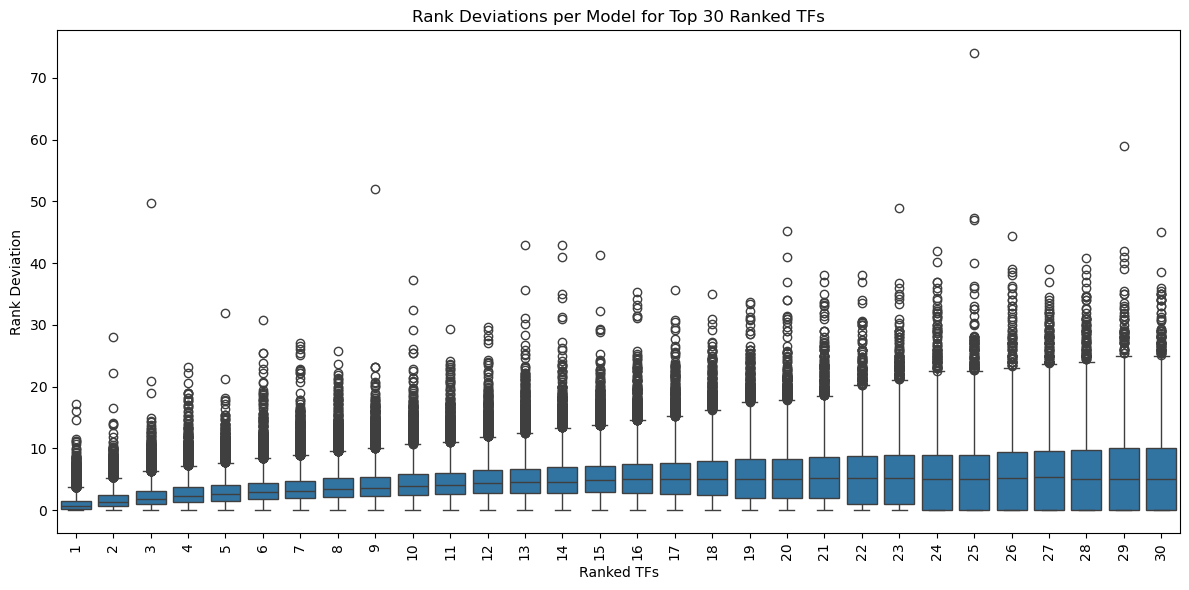

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare lists to hold the data for plotting
rank_deviation_data = {i: [] for i in range(30)}
model = 'exp_exp'

# Iterate over the models in TG_models_scores
for TG in TG_models_scores[model]:
    #print(TG_models_scores[model][TG])
    # find best, second best, third bests... TF
    ranked_TFs = sorted(TG_models_scores[model][TG].keys(), 
                    key=lambda x: TG_models_scores[model][TG][x], reverse=True)
    #print(TG_models_rank_deviation[model][TG][ranked_TFs[0]])
    for i in range(len(ranked_TFs)):
        if i == 30:
            break
        rank_deviation_data[i].append(TG_models_rank_deviation[model][TG][ranked_TFs[i]])

# Convert the rank_deviation_data into a DataFrame for easy plotting
plot_data = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data[i]]  # Create rank labels (1, 2, ..., 30)
})

# Create a boxplot to show the rank deviations for each rank (1st to 30th)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rank', y='Rank Deviation', data=plot_data)
plt.xticks(rotation=90)  # Rotate the x labels for better readability
plt.title('Rank Deviations per Model for Top 30 Ranked TFs')
plt.xlabel('Ranked TFs')
plt.ylabel('Rank Deviation')
plt.tight_layout()
plt.show()

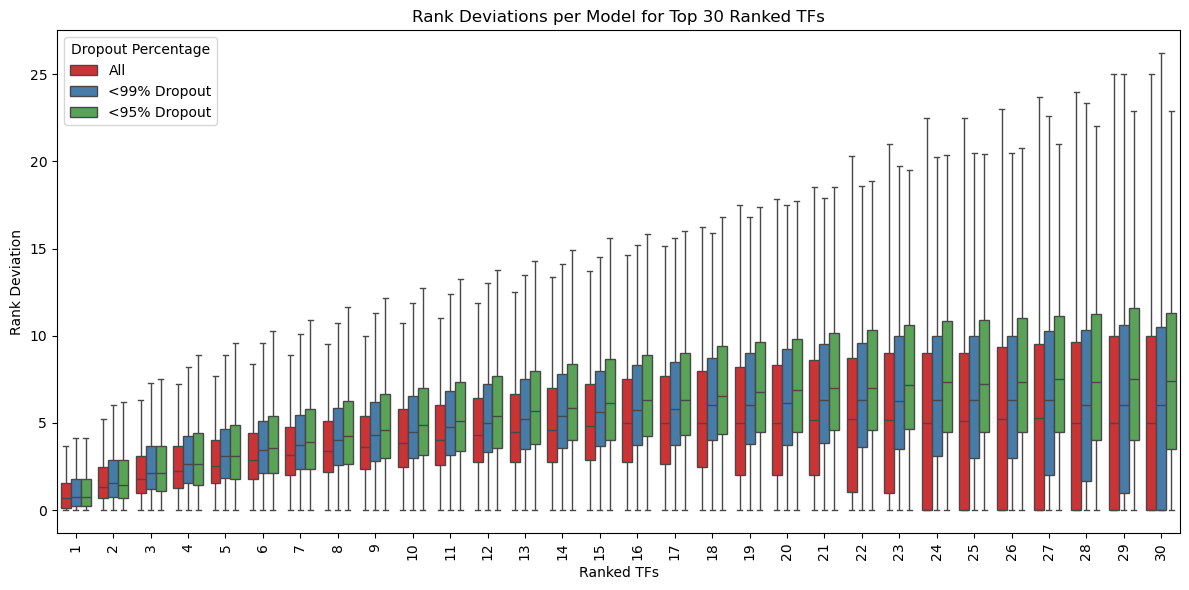

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare lists to hold the data for plotting
rank_deviation_data = {i: [] for i in range(30)}
rank_deviation_data_99 = {i: [] for i in range(30)}
rank_deviation_data_95 = {i: [] for i in range(30)}
model = 'exp_exp'

# Iterate over the models in TG_models_scores
for TG in TG_models_scores[model]:
    # Find best, second best, third best TFs based on their score
    ranked_TFs = sorted(TG_models_scores[model][TG].keys(), 
                        key=lambda x: TG_models_scores[model][TG][x], reverse=True)
    
    for i in range(len(ranked_TFs)):
        if i == 30:
            break
        rank_deviation = TG_models_rank_deviation[model][TG][ranked_TFs[i]]
        
        # Append to the main rank_deviation_data
        rank_deviation_data[i].append(rank_deviation)
        
        # Check dropout percentage and append to the appropriate dictionaries
        pct_dropout = adata_filtered.var.loc[TG, 'pct_dropout_by_counts']
        if pct_dropout < 99:
            rank_deviation_data_99[i].append(rank_deviation)
        if pct_dropout < 95:
            rank_deviation_data_95[i].append(rank_deviation)

# Convert the rank_deviation_data into a DataFrame for easy plotting
plot_data = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data[i]],  # Create rank labels (1, 2, ..., 30)
    'Group': ['All'] * sum(len(v) for v in rank_deviation_data.values())
})

# Add data for rank_deviation_data_99
plot_data_99 = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data_99.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data_99[i]],
    'Group': ['<99% Dropout'] * sum(len(v) for v in rank_deviation_data_99.values())
})

# Add data for rank_deviation_data_95
plot_data_95 = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data_95.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data_95[i]],
    'Group': ['<95% Dropout'] * sum(len(v) for v in rank_deviation_data_95.values())
})

# Combine all data into one DataFrame
combined_plot_data = pd.concat([plot_data, plot_data_99, plot_data_95])

# Create a boxplot to show the rank deviations for each rank (1st to 30th) for all groups
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rank', y='Rank Deviation', hue='Group', data=combined_plot_data, 
            palette='Set1', showfliers=False)  # Avoid showing outliers
plt.xticks(rotation=90)  # Rotate the x labels for better readability
plt.title('Rank Deviations per Model for Top 30 Ranked TFs')
plt.xlabel('Ranked TFs')`
plt.ylabel('Rank Deviation')
plt.tight_layout()
plt.legend(title='Dropout Percentage')
plt.show()


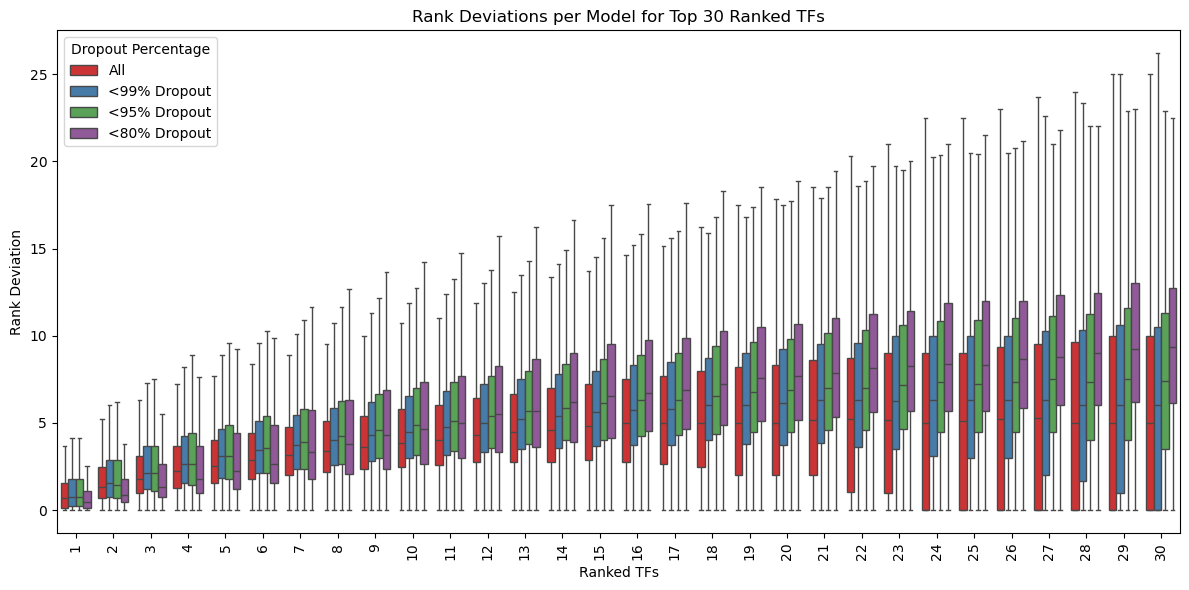

In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare lists to hold the data for plotting
rank_deviation_data = {i: [] for i in range(30)}
rank_deviation_data_99 = {i: [] for i in range(30)}
rank_deviation_data_95 = {i: [] for i in range(30)}
rank_deviation_data_80 = {i: [] for i in range(30)}  # Add a new dictionary for <80% Dropout
model = 'exp_exp'

# Iterate over the models in TG_models_scores
for TG in TG_models_scores[model]:
    # Find best, second best, third best TFs based on their score
    ranked_TFs = sorted(TG_models_scores[model][TG].keys(), 
                        key=lambda x: TG_models_scores[model][TG][x], reverse=True)
    
    for i in range(len(ranked_TFs)):
        if i == 30:
            break
        rank_deviation = TG_models_rank_deviation[model][TG][ranked_TFs[i]]
        
        # Append to the main rank_deviation_data
        rank_deviation_data[i].append(rank_deviation)
        
        # Check dropout percentage and append to the appropriate dictionaries
        pct_dropout = adata_filtered.var.loc[TG, 'pct_dropout_by_counts']
        if pct_dropout < 99:
            rank_deviation_data_99[i].append(rank_deviation)
        if pct_dropout < 95:
            rank_deviation_data_95[i].append(rank_deviation)
        if pct_dropout < 80:  # Check for <80% dropout
            rank_deviation_data_80[i].append(rank_deviation)

# Convert the rank_deviation_data into a DataFrame for easy plotting
plot_data = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data[i]],  # Create rank labels (1, 2, ..., 30)
    'Group': ['All'] * sum(len(v) for v in rank_deviation_data.values())
})

# Add data for rank_deviation_data_99
plot_data_99 = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data_99.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data_99[i]],
    'Group': ['<99% Dropout'] * sum(len(v) for v in rank_deviation_data_99.values())
})

# Add data for rank_deviation_data_95
plot_data_95 = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data_95.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data_95[i]],
    'Group': ['<95% Dropout'] * sum(len(v) for v in rank_deviation_data_95.values())
})

# Add data for rank_deviation_data_80 (new category)
plot_data_80 = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data_80.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data_80[i]],
    'Group': ['<80% Dropout'] * sum(len(v) for v in rank_deviation_data_80.values())
})

# Combine all data into one DataFrame
combined_plot_data = pd.concat([plot_data, plot_data_99, plot_data_95, plot_data_80])

# Create a boxplot to show the rank deviations for each rank (1st to 30th) for all groups
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rank', y='Rank Deviation', hue='Group', data=combined_plot_data, 
            palette='Set1', showfliers=False)  # Avoid showing outliers
plt.xticks(rotation=90)  # Rotate the x labels for better readability
plt.title('Rank Deviations per Model for Top 30 Ranked TFs')
plt.xlabel('Ranked TFs')
plt.ylabel('Rank Deviation')
plt.tight_layout()
plt.legend(title='Dropout Percentage')
plt.show()


In [137]:
len(rank_deviation_data_80[3])

2053

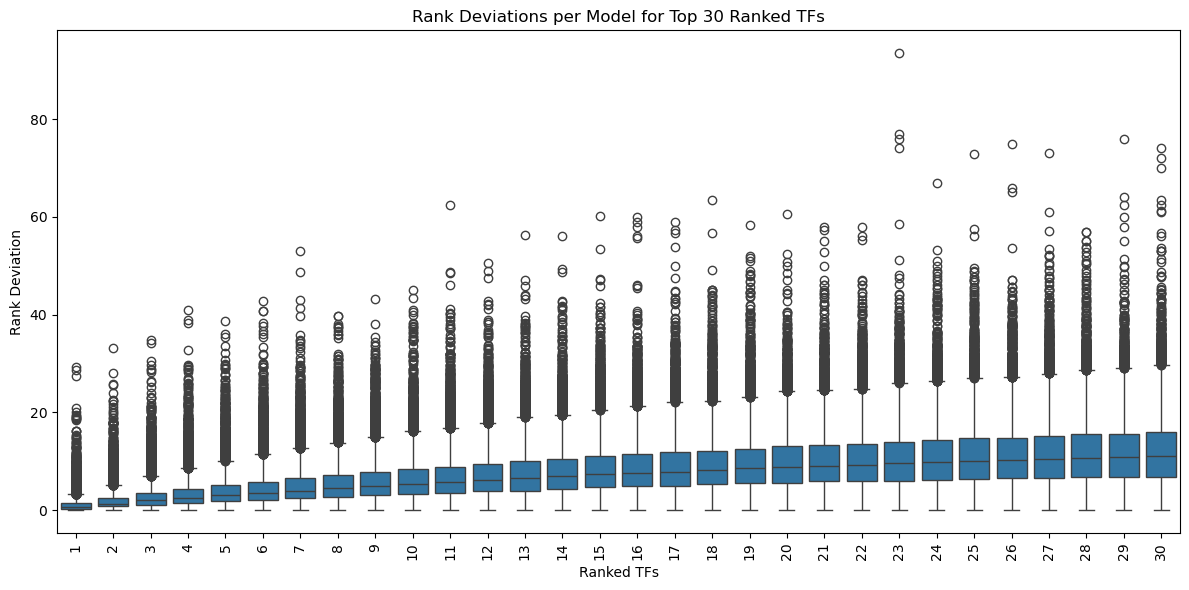

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare lists to hold the data for plotting
rank_deviation_data = {i: [] for i in range(30)}
model = 'act_act'

# Iterate over the models in TG_models_scores
for TG in TG_models_scores[model]:
    #print(TG_models_scores[model][TG])
    # find best, second best, third bests... TF
    ranked_TFs = sorted(TG_models_scores[model][TG].keys(), 
                    key=lambda x: TG_models_scores[model][TG][x], reverse=True)
    #print(TG_models_rank_deviation[model][TG][ranked_TFs[0]])
    for i in range(len(ranked_TFs)):
        if i == 30:
            break
        rank_deviation_data[i].append(TG_models_rank_deviation[model][TG][ranked_TFs[i]])

# Convert the rank_deviation_data into a DataFrame for easy plotting
plot_data = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data[i]]  # Create rank labels (1, 2, ..., 30)
})

# Create a boxplot to show the rank deviations for each rank (1st to 30th)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rank', y='Rank Deviation', data=plot_data)
plt.xticks(rotation=90)  # Rotate the x labels for better readability
plt.title('Rank Deviations per Model for Top 30 Ranked TFs')
plt.xlabel('Ranked TFs')
plt.ylabel('Rank Deviation')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare lists to hold the data for plotting
rank_deviation_data = {i: [] for i in range(30)}
rank_deviation_data_99 = {i: [] for i in range(30)}
rank_deviation_data_95 = {i: [] for i in range(30)}
model = 'exp_exp'

# Iterate over the models in TG_models_scores
for TG in TG_models_scores[model]:
    # Find best, second best, third best TFs based on their score
    ranked_TFs = sorted(TG_models_scores[model][TG].keys(), 
                        key=lambda x: TG_models_scores[model][TG][x], reverse=True)
    
    for i in range(len(ranked_TFs)):
        if i == 30:
            break
        rank_deviation = TG_models_rank_deviation[model][TG][ranked_TFs[i]]
        
        # Append to the main rank_deviation_data
        rank_deviation_data[i].append(rank_deviation)
        
        # Check dropout percentage and append to the appropriate dictionaries
        pct_dropout = adata_filtered.var.loc[TG, 'pct_dropout_by_counts']
        if pct_dropout < 99:
            rank_deviation_data_99[i].append(rank_deviation)
        if pct_dropout < 95:
            rank_deviation_data_95[i].append(rank_deviation)

# Convert the rank_deviation_data into a DataFrame for easy plotting
plot_data = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data[i]],  # Create rank labels (1, 2, ..., 30)
    'Group': ['All'] * sum(len(v) for v in rank_deviation_data.values())
})

# Add data for rank_deviation_data_99
plot_data_99 = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data_99.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data_99[i]],
    'Group': ['<99% Dropout'] * sum(len(v) for v in rank_deviation_data_99.values())
})

# Add data for rank_deviation_data_95
plot_data_95 = pd.DataFrame({
    'Rank Deviation': [val for sublist in rank_deviation_data_95.values() for val in sublist],
    'Rank': [i+1 for i in range(30) for _ in rank_deviation_data_95[i]],
    'Group': ['<95% Dropout'] * sum(len(v) for v in rank_deviation_data_95.values())
})

# Combine all data into one DataFrame
combined_plot_data = pd.concat([plot_data, plot_data_99, plot_data_95])

# Create a boxplot to show the rank deviations for each rank (1st to 30th) for all groups
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rank', y='Rank Deviation', hue='Group', data=combined_plot_data, 
            palette='Set1', showfliers=False)  # Avoid showing outliers
plt.xticks(rotation=90)  # Rotate the x labels for better readability
plt.title('Rank Deviations per Model for Top 30 Ranked TFs')
plt.xlabel('Ranked TFs')
plt.ylabel('Rank Deviation')
plt.tight_layout()
plt.legend(title='Dropout Percentage')
plt.show()


In [127]:
# Correlation between ATAC-seq and RNA-seq values?
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

adata_annotation = sc.read_h5ad( get_annotation_adata)
expression_adata = sc.read_h5ad( path_to_expression)
expression_adata = adata[adata.obs.index.isin(adata_annotation.obs_names)].copy()
geneactivity_adata = sc.read_h5ad(path_to_geneactivity)

# Step 1: Identify common genes
common_genes = set(expression_adata.var_names) & set(geneactivity_adata.var_names)

# Step 2: Filter both AnnData objects
expression_filtered = expression_adata[:, expression_adata.var_names.isin(common_genes)].copy()
geneactivity_filtered = geneactivity_adata[:, geneactivity_adata.var_names.isin(common_genes)].copy()

# Step 3: Compute `log1p_mean_counts` for geneactivity_adata
geneactivity_filtered.var['log1p_mean_counts'] = np.log1p(geneactivity_filtered.X.mean(axis=0).A1)

# Step 4: Prepare a DataFrame for plotting
df = pd.DataFrame({
    'Expression log1p_mean_counts': expression_filtered.var['log1p_mean_counts'],
    'Gene Activity log1p_mean_counts': geneactivity_filtered.var['log1p_mean_counts']
})


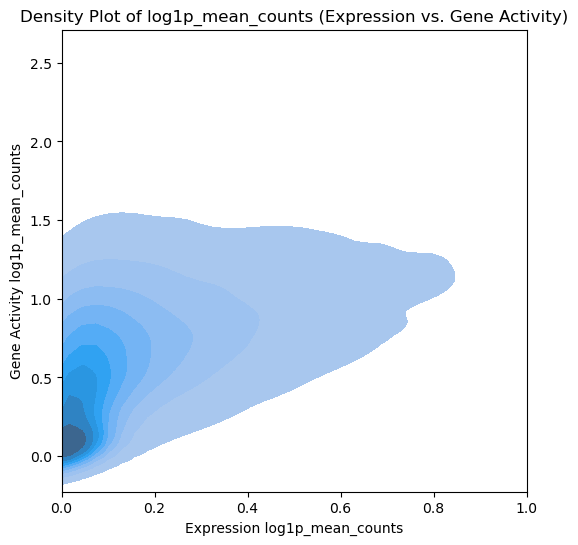

In [129]:

# Step 5: Create a density plot
plt.figure(figsize=(6, 6))
sns.kdeplot(data=df, x='Expression log1p_mean_counts', y='Gene Activity log1p_mean_counts', fill=True)

# Set x-axis limits
plt.xlim(0, 1)  # Adjust the range as needed

plt.xlabel('Expression log1p_mean_counts')
plt.ylabel('Gene Activity log1p_mean_counts')
plt.title('Density Plot of log1p_mean_counts (Expression vs. Gene Activity)')
plt.show()

In [130]:
from scipy.stats import spearmanr, pearsonr

print(spearmanr(df['Expression log1p_mean_counts'], df['Gene Activity log1p_mean_counts']))
print(pearsonr(df['Expression log1p_mean_counts'], df['Gene Activity log1p_mean_counts']))

SignificanceResult(statistic=0.7159397210577929, pvalue=0.0)
PearsonRResult(statistic=0.4567950277708457, pvalue=0.0)


# Chapter 4: Difference between networks on raw counts and normalized counts
- Counts are used as they come, as opposed to library normalization + log1p normalization

In [139]:
# Folder set-up
result_folder_1       = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/thesis_chapters/chapter_1/'
path_to_expression    = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/data/human_PBMC_10x_10k/pbmc_granulocyte_sorted_10k_gex_molecule_info_filtered_mg_mc_gc_mt_tc.h5ad'#'/scratch/gent/vo/000/gvo00027/projects/CBIGR/25MDT_PBMC_10xmultiome/PBMC_manual_anno_Jens/pbmc_granulocyte_sorted_10k_gex_molecule_info_manual_annotation.h5ad'
path_to_signature     = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/run_2/models_pruned/gene_signatures_AUCell/'
path_to_regulons      = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/run_2/models_pruned/'
get_annotation_adata  = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/25MDT_PBMC_10xmultiome/PBMC_manual_anno_Jens/pbmc_granulocyte_sorted_10k_gex_molecule_info_manual_annotation.h5ad'

models = ['exp_exp', 'expCOP_exp',  'expCOP_act', 'act_act', 'exp_act', 'act_exp']

adata_annotation = sc.read_h5ad( get_annotation_adata)
adata = sc.read_h5ad( path_to_expression)
adata_filtered = adata[adata.obs.index.isin(adata_annotation.obs_names)].copy()
ex_matrix = pd.DataFrame(data = adata_filtered.X.toarray(), index=adata_filtered.obs_names, columns=adata_filtered.var_names)


In [145]:
# lets start with loading the XGBoost outputs first

# set up pathes
base_result_path = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/'
run_name         = 'run_2/' # this is the run on raw data
models = ['exp_exp', 'expCOP_exp',  'expCOP_act', 'act_act', 'exp_act', 'act_exp']

# Define data structure
TG_models_scores            = {}
TG_models_rank_deviation    = {}
TG_models_evals             = {}
TG_models_pred_performance  = {}

# load results: adapt ranges towards how the model was split
for m in models:

    path = base_result_path+run_name+'/model_'+ m + '/'

    # load scores
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_scores.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_scores:
                TG_models_scores[m] = scores
            else:
                TG_models_scores[m].update(scores)
                
    # load rank deviations
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_scores_rank_deviation.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_rank_deviation:
                TG_models_rank_deviation[m] = scores
            else:
                TG_models_rank_deviation[m].update(scores)
                
    # load model evals
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_evals.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_evals:
                TG_models_evals[m] = scores
            else:
                TG_models_evals[m].update(scores)        
                
    # load model performacnce
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_predictive_performance.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_pred_performance:
                TG_models_pred_performance[m] = scores
            else:
                TG_models_pred_performance[m].update(scores) 
# make networks
k            = 10
n_edges      = 50000
min_reg_size = 10
filter_TGs   = None

regulons_all_RAW                    = {}
interactions_all_RAW                = {}
TF_TG_interactions_binary_all_RAW   = {}
TF_TG_interactions_weighted_all_RAW = {}

# create the desiderd networks
for model in models:
    print(model)
    new_scores     = normalizeImportanceScores(TG_models_scores[model], top_k_threshold=k)
    if "COP" in model:
        print('COP detected')
        new_scores     = delineateComplexScores(TG_models_scores[model])
    new_scores_all = normalizeForModelPerformance(new_scores, TG_models_pred_performance[model])
    regulons_all_RAW[model], interactions_all_RAW[model], TF_TG_interactions_binary_all_RAW[model], TF_TG_interactions_weighted_all_RAW[model] = makeCustomNetwork(new_scores_all, minimum_regulon_size=min_reg_size, number_edges=n_edges, filter_TGs=filter_TGs, verbose=False)

exp_exp
expCOP_exp
COP detected
expCOP_act
COP detected
act_act
exp_act
act_exp


In [146]:
# lets start with loading the XGBoost outputs first

# set up pathes
base_result_path = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/'
run_name         = 'run_3/' # this is the run on normalzied data
models = ['exp_exp', 'expCOP_exp',  'expCOP_act', 'act_act', 'exp_act', 'act_exp']

# Define data structure
TG_models_scores            = {}
TG_models_rank_deviation    = {}
TG_models_evals             = {}
TG_models_pred_performance  = {}

# load results: adapt ranges towards how the model was split
for m in models:

    path = base_result_path+run_name+'/model_'+ m + '/'

    # load scores
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_scores.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_scores:
                TG_models_scores[m] = scores
            else:
                TG_models_scores[m].update(scores)
                
    # load rank deviations
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_scores_rank_deviation.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_rank_deviation:
                TG_models_rank_deviation[m] = scores
            else:
                TG_models_rank_deviation[m].update(scores)
                
    # load model evals
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_evals.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_evals:
                TG_models_evals[m] = scores
            else:
                TG_models_evals[m].update(scores)        
                
    # load model performacnce
    for i in range(0, 19000, 1000):
        with gzip.open(path+'/model_' + str(i) +'_'+ str(i+999) +'_predictive_performance.pkl', 'rb') as handle:
            scores = pickle.load(handle)
            if m not in TG_models_pred_performance:
                TG_models_pred_performance[m] = scores
            else:
                TG_models_pred_performance[m].update(scores) 
# make networks
k            = 10
n_edges      = 50000
min_reg_size = 10
filter_TGs   = None

regulons_all_NORM                    = {}
interactions_all_NORM                = {}
TF_TG_interactions_binary_all_NORM   = {}
TF_TG_interactions_weighted_all_NORM = {}

# create the desiderd networks
for model in models:
    print(model)
    new_scores     = normalizeImportanceScores(TG_models_scores[model], top_k_threshold=k)
    if "COP" in model:
        print('COP detected')
        new_scores     = delineateComplexScores(TG_models_scores[model])
    new_scores_all = normalizeForModelPerformance(new_scores, TG_models_pred_performance[model])
    regulons_all_NORM[model], interactions_all_NORM[model], TF_TG_interactions_binary_all_NORM[model], TF_TG_interactions_weighted_all_NORM[model] = makeCustomNetwork(new_scores_all, minimum_regulon_size=min_reg_size, number_edges=n_edges, filter_TGs=filter_TGs, verbose=False)

exp_exp
expCOP_exp
COP detected
expCOP_act
COP detected
act_act
exp_act
act_exp


            exp_exp  expCOP_exp  expCOP_act  act_act  exp_act  act_exp
exp_exp       1.000       0.465       0.210    0.837    0.676    0.841
expCOP_exp    0.465       1.000       0.263    0.472    0.367    0.506
expCOP_act    0.210       0.263       1.000    0.215    0.239    0.210
act_act       0.837       0.472       0.215    1.000    0.639    0.863
exp_act       0.676       0.367       0.239    0.639    1.000    0.572
act_exp       0.841       0.506       0.210    0.863    0.572    1.000


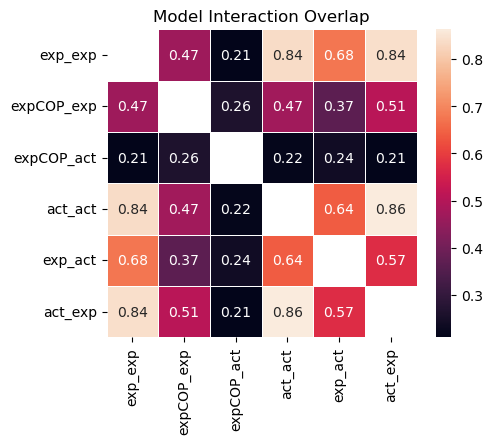

In [148]:
import numpy as np
import pandas as pd

# Extract interactions as sets per model
model_interactions = {model: set(regulons_all[model].keys()) for model in regulons_all}

# Initialize an empty matrix
overlap_matrix = np.zeros((len(models), len(models)))

# Calculate pairwise overlaps (e.g., Jaccard index or intersection size)
for i, model1 in enumerate(models):
    for j, model2 in enumerate(models):
        if i <= j:  # Only calculate once per pair
            set1 = model_interactions[model1]
            set2 = model_interactions[model2]
            
            # Jaccard index: Intersection / Union
            intersection_size = len(set1 & set2)
            union_size = len(set1 | set2)
            overlap = intersection_size / union_size if union_size > 0 else 0

            # Store the overlap in the matrix (symmetric)
            overlap_matrix[i][j] = overlap
            overlap_matrix[j][i] = overlap

# Convert to a pandas DataFrame for easier visualization
overlap_df = pd.DataFrame(overlap_matrix, index=models, columns=models)

# Display the matrix nicely
print(overlap_df.round(3))

plt.figure(figsize=(5, 4))
mask = np.eye(len(models), dtype=bool)  # Mask to grey-out the diagonal
sns.heatmap(overlap_df, annot=True,  mask=mask, linewidths=0.5)#, cmap="Blues",
plt.title("Model Interaction Overlap")
plt.show()


                exp_exp_NORM  expCOP_exp_NORM  expCOP_act_NORM  act_act_NORM  \
exp_exp_RAW            0.897            0.435            0.215         0.812   
expCOP_exp_RAW         0.462            0.743            0.273         0.474   
expCOP_act_RAW         0.280            0.341            0.637         0.287   
act_act_RAW            0.565            0.372            0.227         0.608   
exp_act_RAW            0.759            0.410            0.247         0.726   
act_exp_RAW            0.859            0.501            0.205         0.870   

                exp_act_NORM  act_exp_NORM  
exp_exp_RAW            0.720         0.793  
expCOP_exp_RAW         0.368         0.495  
expCOP_act_RAW         0.300         0.279  
act_act_RAW            0.516         0.573  
exp_act_RAW            0.771         0.656  
act_exp_RAW            0.584         0.971  


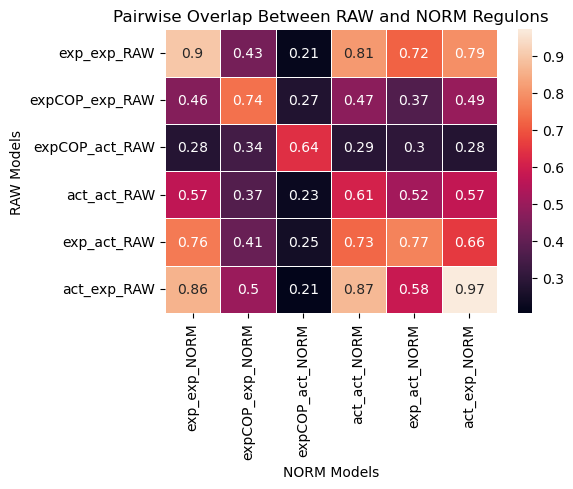

In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract interactions as sets per model for both RAW and NORM
model_interactions = {}

# Add RAW models
for model in regulons_all:
    model_interactions[model + '_RAW'] = set(regulons_all_RAW[model].keys())

# Add NORM models
for model in regulons_all:
    model_interactions[model + '_NORM'] = set(regulons_all_NORM[model].keys())

# Get the list of RAW models (y-axis) and NORM models (x-axis)
raw_models = [model + '_RAW' for model in regulons_all_RAW]
norm_models = [model + '_NORM' for model in regulons_all_NORM]

# Initialize an empty matrix to store overlap values
overlap_matrix = np.zeros((len(raw_models), len(norm_models)))

# Calculate pairwise overlaps between RAW and NORM models (e.g., Jaccard index or intersection size)
for i, model1 in enumerate(raw_models):
    for j, model2 in enumerate(norm_models):
        set1 = model_interactions[model1]
        #print(set1)
        #break
        set2 = model_interactions[model2]
        # Jaccard index: Intersection / Union
        intersection_size = len(set1 & set2)
        union_size = len(set1 | set2)
        overlap = intersection_size / union_size if union_size > 0 else 0
        #print(model1, model2, len(set1), len(set2), intersection_size, union_size, overlap)
        # Store the overlap in the matrix
        overlap_matrix[i][j] = overlap

# Convert to a pandas DataFrame for easier visualization
overlap_df = pd.DataFrame(overlap_matrix, index=raw_models, columns=norm_models)

# Display the matrix nicely
print(overlap_df.round(3))

# Plot the heatmap for the overlap matrix
plt.figure(figsize=(6, 5))
sns.heatmap(overlap_df, annot=True, linewidths=0.5)
plt.title("Pairwise Overlap Between RAW and NORM Regulons")
plt.xlabel('NORM Models')
plt.ylabel('RAW Models')
#plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.tight_layout()
plt.show()


                exp_exp_NORM  expCOP_exp_NORM  expCOP_act_NORM  act_act_NORM  \
exp_exp_RAW            0.192            0.025            0.014         0.042   
expCOP_exp_RAW         0.018            0.138            0.035         0.007   
expCOP_act_RAW         0.012            0.049            0.176         0.015   
act_act_RAW            0.034            0.008            0.015         0.107   
exp_act_RAW            0.063            0.015            0.031         0.084   
act_exp_RAW            0.051            0.011            0.010         0.058   

                exp_act_NORM  act_exp_NORM  
exp_exp_RAW            0.066         0.051  
expCOP_exp_RAW         0.010         0.009  
expCOP_act_RAW         0.024         0.008  
act_act_RAW            0.062         0.040  
exp_act_RAW            0.230         0.038  
act_exp_RAW            0.040         0.187  


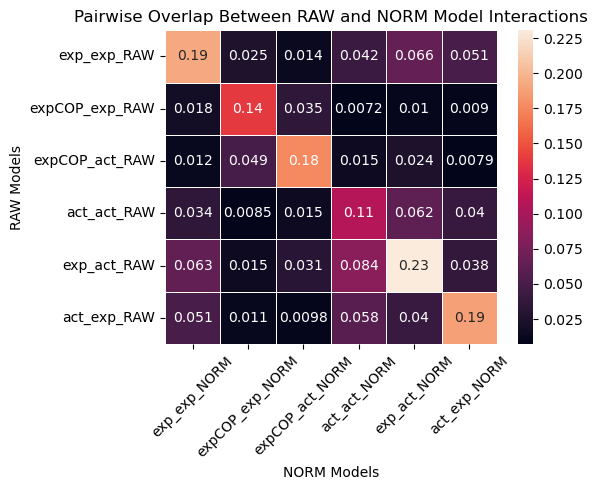

In [187]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract interactions as sets per model for both RAW and NORM
interaction_sets = {}

# Add RAW model interactions
for model in interactions_all:
    # Assuming 'interactions_all[model]' contains a dictionary where the keys are interactions
    interaction_sets[model + '_RAW'] = set(interactions_all_RAW[model].keys())

# Add NORM model interactions
for model in interactions_all_NORM:
    # Assuming 'interactions_all_NORM[model]' contains a dictionary where the keys are interactions
    interaction_sets[model + '_NORM'] = set(interactions_all_NORM[model].keys())

# Get the list of RAW models (y-axis) and NORM models (x-axis)
raw_models = [model + '_RAW' for model in interactions_all_RAW]
norm_models = [model + '_NORM' for model in interactions_all_NORM]

# Initialize an empty matrix to store overlap values
overlap_matrix = np.zeros((len(raw_models), len(norm_models)))

# Calculate pairwise overlaps between RAW and NORM models (e.g., Jaccard index or intersection size)
for i, model1 in enumerate(raw_models):
    for j, model2 in enumerate(norm_models):
        # Extract the interaction sets for each model
        set1 = interaction_sets[model1]
        set2 = interaction_sets[model2]

        # Jaccard index: Intersection / Union
        intersection_size = len(set1.intersection(set2))  # Intersection size
        union_size = len(set1.union(set2))  # Union size
        #print(len(set1), len(set2), intersection_size,union_size)
        
        # To prevent perfect overlap due to misinterpretation
        overlap = intersection_size / union_size if union_size > 0 else 0

        # Store the overlap in the matrix
        overlap_matrix[i][j] = overlap

# Convert to a pandas DataFrame for easier visualization
overlap_df = pd.DataFrame(overlap_matrix, index=raw_models, columns=norm_models)

# Display the matrix nicely
print(overlap_df.round(3))

# Plot the heatmap for the overlap matrix
plt.figure(figsize=(6, 5))
sns.heatmap(overlap_df, annot=True, linewidths=0.5)
plt.title("Pairwise Overlap Between RAW and NORM Model Interactions")
plt.xlabel('NORM Models')
plt.ylabel('RAW Models')
plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.tight_layout()
plt.show()


                exp_exp_NORM  expCOP_exp_NORM  expCOP_act_NORM  act_act_NORM  \
exp_exp_RAW            0.000            0.005            0.002        -0.001   
expCOP_exp_RAW         0.005            0.000            0.015         0.001   
expCOP_act_RAW         0.002            0.015            0.000         0.007   
act_act_RAW           -0.001            0.001            0.007         0.000   
exp_act_RAW            0.000            0.003            0.005         0.035   
act_exp_RAW            0.002            0.002            0.002         0.018   

                exp_act_NORM  act_exp_NORM  
exp_exp_RAW            0.000         0.002  
expCOP_exp_RAW         0.003         0.002  
expCOP_act_RAW         0.005         0.002  
act_act_RAW            0.035         0.018  
exp_act_RAW            0.000         0.000  
act_exp_RAW            0.000         0.000  


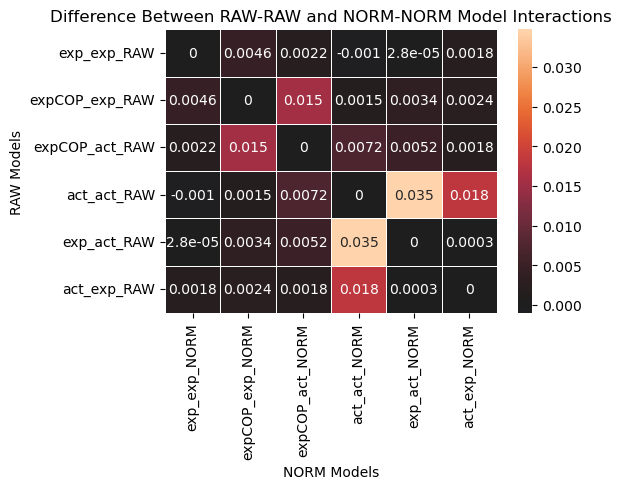

In [199]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract interactions as sets per model for both RAW and NORM
interaction_sets = {}

# Add RAW model interactions
for model in interactions_all:
    # Assuming 'interactions_all[model]' contains a dictionary where the keys are interactions
    interaction_sets[model + '_RAW'] = set(interactions_all_RAW[model].keys())

# Add NORM model interactions
for model in interactions_all_NORM:
    # Assuming 'interactions_all_NORM[model]' contains a dictionary where the keys are interactions
    interaction_sets[model + '_NORM'] = set(interactions_all_NORM[model].keys())

# Get the list of RAW models (y-axis) and NORM models (x-axis)
raw_models = [model + '_RAW' for model in interactions_all_RAW]
norm_models = [model + '_NORM' for model in interactions_all_NORM]

# Initialize empty matrices to store overlap values for NORM-NORM and RAW-RAW
overlap_matrix_norm = np.zeros((len(norm_models), len(norm_models)))
overlap_matrix_raw = np.zeros((len(raw_models), len(raw_models)))

# Calculate pairwise overlaps for NORM-NORM models
for i, model1 in enumerate(norm_models):
    for j, model2 in enumerate(norm_models):
        if i <= j:  # Only calculate once per pair
            set1 = interaction_sets[model1]
            set2 = interaction_sets[model2]
            
            # Jaccard index: Intersection / Union
            intersection_size = len(set1 & set2)
            union_size = len(set1 | set2)
            overlap_norm = intersection_size / union_size if union_size > 0 else 0

            # Store the overlap in the matrix (symmetric)
            overlap_matrix_norm[i][j] = overlap_norm
            overlap_matrix_norm[j][i] = overlap_norm

# Calculate pairwise overlaps for RAW-RAW models
for i, model1 in enumerate(raw_models):
    for j, model2 in enumerate(raw_models):
        if i <= j:  # Only calculate once per pair
            set1 = interaction_sets[model1]
            set2 = interaction_sets[model2]
            
            # Jaccard index: Intersection / Union
            intersection_size = len(set1 & set2)
            union_size = len(set1 | set2)
            overlap_raw = intersection_size / union_size if union_size > 0 else 0

            # Store the overlap in the matrix (symmetric)
            overlap_matrix_raw[i][j] = overlap_raw
            overlap_matrix_raw[j][i] = overlap_raw

# Subtract NORM-NORM matrix from RAW-RAW matrix
# For consistency, both matrices are of the same shape
overlap_difference =  overlap_matrix_norm - overlap_matrix_raw

# Convert the difference matrix into a pandas DataFrame for easier visualization
overlap_diff_df = pd.DataFrame(overlap_difference, index=raw_models, columns=norm_models)

# Display the matrix nicely
print(overlap_diff_df.round(3))

# Plot the heatmap for the overlap difference
plt.figure(figsize=(6, 5))
sns.heatmap(overlap_diff_df, annot=True,  linewidths=0.5, center=0)
plt.title("Difference Between RAW-RAW and NORM-NORM Model Interactions")
plt.xlabel('NORM Models')
plt.ylabel('RAW Models')
#plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.tight_layout()
plt.show()


                exp_exp_NORM  expCOP_exp_NORM  expCOP_act_NORM  act_act_NORM  \
exp_exp_RAW            0.000            0.021           -0.069         0.279   
expCOP_exp_RAW         0.021            0.000           -0.098         0.072   
expCOP_act_RAW        -0.069           -0.098            0.000        -0.069   
act_act_RAW            0.279            0.072           -0.069         0.000   
exp_act_RAW           -0.089           -0.039           -0.074         0.071   
act_exp_RAW            0.031            0.012           -0.063         0.296   

                exp_act_NORM  act_exp_NORM  
exp_exp_RAW           -0.089         0.031  
expCOP_exp_RAW        -0.039         0.012  
expCOP_act_RAW        -0.074        -0.063  
act_act_RAW            0.071         0.296  
exp_act_RAW            0.000        -0.098  
act_exp_RAW           -0.098         0.000  


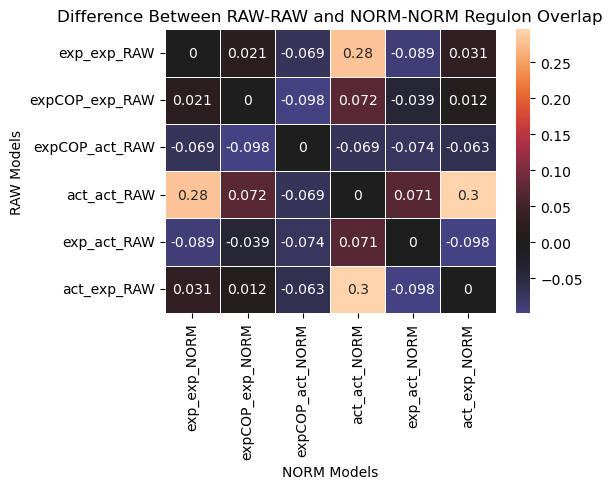

In [198]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract regulons as sets per model for both RAW and NORM
regulon_sets = {}

# Add RAW model regulons
for model in regulons_all_RAW:
    # Assuming 'regulons_all_RAW[model]' contains a dictionary where the keys are regulons
    regulon_sets[model + '_RAW'] = set(regulons_all_RAW[model].keys())

# Add NORM model regulons
for model in regulons_all_NORM:
    # Assuming 'regulons_all_NORM[model]' contains a dictionary where the keys are regulons
    regulon_sets[model + '_NORM'] = set(regulons_all_NORM[model].keys())

# Get the list of RAW models (y-axis) and NORM models (x-axis)
raw_models = [model + '_RAW' for model in regulons_all_RAW]
norm_models = [model + '_NORM' for model in regulons_all_NORM]

# Initialize empty matrices to store overlap values for NORM-NORM and RAW-RAW
overlap_matrix_norm = np.zeros((len(norm_models), len(norm_models)))
overlap_matrix_raw = np.zeros((len(raw_models), len(raw_models)))

# Calculate pairwise overlaps for NORM-NORM models (for regulons)
for i, model1 in enumerate(norm_models):
    for j, model2 in enumerate(norm_models):
        if i <= j:  # Only calculate once per pair
            set1 = regulon_sets[model1]
            set2 = regulon_sets[model2]
            
            # Jaccard index: Intersection / Union
            intersection_size = len(set1 & set2)
            union_size = len(set1 | set2)
            overlap_norm = intersection_size / union_size if union_size > 0 else 0

            # Store the overlap in the matrix (symmetric)
            overlap_matrix_norm[i][j] = overlap_norm
            overlap_matrix_norm[j][i] = overlap_norm

# Calculate pairwise overlaps for RAW-RAW models (for regulons)
for i, model1 in enumerate(raw_models):
    for j, model2 in enumerate(raw_models):
        if i <= j:  # Only calculate once per pair
            set1 = regulon_sets[model1]
            set2 = regulon_sets[model2]
            
            # Jaccard index: Intersection / Union
            intersection_size = len(set1 & set2)
            union_size = len(set1 | set2)
            overlap_raw = intersection_size / union_size if union_size > 0 else 0

            # Store the overlap in the matrix (symmetric)
            overlap_matrix_raw[i][j] = overlap_raw
            overlap_matrix_raw[j][i] = overlap_raw

# Subtract NORM-NORM matrix from RAW-RAW matrix
# For consistency, both matrices are of the same shape
overlap_difference =  overlap_matrix_norm - overlap_matrix_raw

# Convert the difference matrix into a pandas DataFrame for easier visualization
overlap_diff_df = pd.DataFrame(overlap_difference, index=raw_models, columns=norm_models)

# Display the matrix nicely
print(overlap_diff_df.round(3))

# Plot the heatmap for the overlap difference
plt.figure(figsize=(6, 5))
sns.heatmap(overlap_diff_df, annot=True, linewidths=0.5, center=0)
plt.title("Difference Between RAW-RAW and NORM-NORM Regulon Overlap")
plt.xlabel('NORM Models')
plt.ylabel('RAW Models')
#plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.tight_layout()
plt.show()
